In [0]:
#%pip install skope-rules
#%pip install feature_selector
#%pip install numpy --upgrade
#%pip install pandas --upgrade

In [2]:
import sklearn
import pandas as pd
import numpy as np
from itertools import product
import collections
from sklearn import tree
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from sklearn.model_selection import StratifiedKFold
import matplotlib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from skrules import SkopeRules
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from feature_selector import FeatureSelector
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# Predicting Defaulting Vehicle Loans for the First Equated Monthly Instalments

As the title suggests, the aim of the project is to predict if a borrower will default on a vehicle loan in the first Equated Monthly Instalments (EMI). Financial institutions make money off the interest paid on loans. When borrowers default, this has a high impact on their earnings. In fact, making poor credit decisions will lead to less resources for offering more loans . The novelty of this project is to use an ensemble of machine learning algorithms from all families covered in CSI5155 to build binary classifiers that predict the ability to repay the loans. This project will follow a strict methodology starting by conducting a literature review. After, the dataset will be cleaned, pre-processed and split into training and testing sets. Then models will be constructed, evaluated and compared using proper metrics along with error analysis. One limitation is that the data only contains information about loans that were offered, which means there is a lack of information on rejected loans.

## Import Data Set
The dataset named L&T Vehicle Loan Default Prediction  can be retrieved from Kaggle. The dataset has 233,154 rows and 41 features, where every row represents a single loan. One of the features is named loan_default which will be used as the label. It is a binary field where '1' means the borrower defaulted in the first EMI and '0' means the borrower didn’t default in the first EMI. The dataset is imbalanced because amongst the 233,000 instances, 182,543 are labeled as ‘0’ and 50,611 as ‘1’ which is the positive class. The other features provide details about the loan itself like disbursal details and loan to value ratio. It also contains information regarding the borrower such as demographic data. The dataset contains both categorical and numerical data.


In [6]:
# import data
data = pd.read_csv('train.csv')
data

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,01-08-88,Salaried,26-10-18,6,3705,1,0,0,1,0,0,735,D-Very Low Risk,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0
233150,606141,73651,100600,74.95,34,23775,51,990,05-12-88,Self employed,23-10-18,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0
233151,613658,33484,71212,48.45,77,22186,86,2299,01-06-76,Salaried,24-10-18,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,26-03-94,Salaried,29-09-18,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [8]:
data.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


## 1. Features Engineering

A description of the features is presented in the table below. 

In [9]:
features_description = pd.read_csv('features.csv', encoding = "ISO-8859-1")
features_description

,Variable Name,Description
0,UniqueID,Identifier for customers
1,loan_default,Payment default in the first EMI on due date
2,disbursed_amount,Amount of Loan disbursed
3,asset_cost,Cost of the Asset
4,ltv,Loan to Value of the asset
5,branch_id,Branch where the loan was disbursed
6,supplier_id,Vehicle Dealer where the loan was disbursed
7,manufacturer_id,"Vehicle manufacturer(Hero, Honda, TVS etc.)"
8,Current_pincode,Current pincode of the customer
9,Date.of.Birth,Date of birth of the customer


### 1.1 Missing Values

In [10]:
## Verifiy if there are some missing values
data.isna().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

We can see above that the only feature that has missing values is the Employment.Type. In fact, 7661 instances have no value for this feature amongst 233,154 instances (about 3%). That being said, the instances that don't have a value for Employment.Type will get 'Not Specified' instead. It's important to note that the mode cannot be used because the nature of the missing values is unknown. For example, it could be a human error or the applicant doesn't have a salary. 

In [0]:
data = data.replace(np.nan,'Not Specified')

### 1.2 Handle Categorical Features

Thee are four categorical features in the dataset. The feature named Employment.Type has three distinct values: Salaried, Self employed and Not Specified. Since there are only three distinct values, the One-Hot Decoding process is applied for this feature resulting in three different colomn.


In [0]:
data_emp = pd.get_dummies(data[['Employment.Type']],prefix='Employment')

In [0]:
data = data.drop(columns=['Employment.Type'])
df = pd.concat([data_emp,data], axis=1)

There are two features named AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH that are also categorical. These features contain a string of this format: 'Xyrs Ymon' where X and Y are numbers. A script will be ran in order to modify the value to the total number of months. 

In [0]:
def get_total_number_months(stri):
    years_month = stri[0:6].split("yrs ")
    return int(years_month[0])*12 + int(years_month[0])

In [0]:
df['AVERAGE.ACCT.AGE_MONTHS'] = df['AVERAGE.ACCT.AGE'].apply(get_total_number_months)
df['CREDIT.HISTORY.LENGTH_MONTHS'] = df['CREDIT.HISTORY.LENGTH'].apply(get_total_number_months)
df = df.drop(columns=['AVERAGE.ACCT.AGE'])
df = df.drop(columns=['CREDIT.HISTORY.LENGTH'])

The last categorical feature is named PERFORM_CNS.SCORE.DESCRIPTION. There are 20 unique values for this feature.
That being said, applying the One-Hot Decoding process will result in 20 columns for this feature, which is too much. 

In [0]:
df=df.sort_values(by=['PERFORM_CNS.SCORE.DESCRIPTION'])
df1 = df[['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE']]

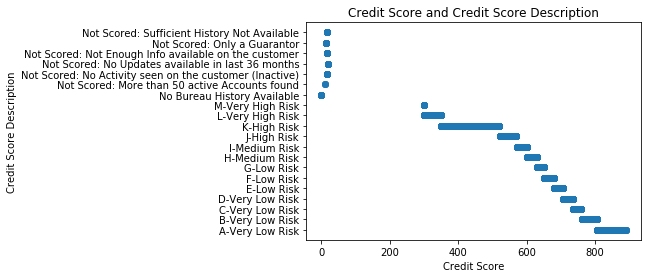

In [17]:
plt.title('Credit Score and Credit Score Description')
plt.xlabel('Credit Score')
plt.ylabel('Credit Score Description')
plt.scatter(y=df1['PERFORM_CNS.SCORE.DESCRIPTION'],x=df1['PERFORM_CNS.SCORE'])

Since the feature PERFORM_CNS.SCORE.DESCRIPTION is ordinal, the values will be replaced by a number:
'No Bureau History Available' = 1

'Not Scored: More than 50 active Accounts found = 1

'Not Scored: No Activity seen on the customer (Inactive) =1

'Not Scored: No Updates available in last 36 months =1 

'Not Scored: Not Enough Info available on the customer =1 

'Not Scored: Only a Guarantor =1 

'Not Scored: Sufficient History Not Available =1 

'No Bureau History Available' = 1

'M-Very High Risk' = 2

'L-Very High Risk' = 3

'K-High Risk' = 4

'J-High Risk' = 5

'I-Medium Risk' = 6

'H-Medium Risk' = 7

'G-Low Risk' = 8

'F-Low Risk' = 9

'E-Low Risk' = 10

'D-Very Low Risk' = 11

'C-Very Low Risk' = 12

'B-Very Low Risk' = 13

A-Very Low Risk = 14

In [0]:
df[['PERFORM_CNS.SCORE.DESCRIPTION']] = df[['PERFORM_CNS.SCORE.DESCRIPTION']].replace(
    ['A-Very Low Risk', 'B-Very Low Risk', 
     'C-Very Low Risk', 'D-Very Low Risk', 'E-Low Risk','F-Low Risk','G-Low Risk', 'H-Medium Risk',
     'I-Medium Risk', 'J-High Risk' , 'K-High Risk', 'L-Very High Risk', 'M-Very High Risk',
    'Not Scored: Sufficient History Not Available','Not Scored: Only a Guarantor', 
     'Not Scored: Not Enough Info available on the customer', 
     'Not Scored: No Updates available in last 36 months', 'Not Scored: No Activity seen on the customer (Inactive)'
     'Not Scored: More than 50 active Accounts found', 'No Bureau History Available', 'Not Scored: No Activity seen on the customer (Inactive)', 'Not Scored: More than 50 active Accounts found'], 
    [14,13,12,11,10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1])

### 1.3 Handle Date Features

There are two date features in the data set. The feature will be transformed in three different columns, one for the year, one for the month and one for the day.

In [0]:
df['Date.of.Birth']=pd.to_datetime(df['Date.of.Birth'])
df['Date.of.Birth.year'] = pd.DatetimeIndex(df['Date.of.Birth']).year
df['Date.of.Birth.month'] = pd.DatetimeIndex(df['Date.of.Birth']).month
df['Date.of.Birth.day'] = pd.DatetimeIndex(df['Date.of.Birth']).day
df = df.drop(columns=['Date.of.Birth'])
df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'])
df['DisbursalDate.year'] = pd.DatetimeIndex(df['DisbursalDate']).year
df['DisbursalDate.month'] = pd.DatetimeIndex(df['DisbursalDate']).month
df['DisbursalDate.day'] = pd.DatetimeIndex(df['DisbursalDate']).day
df = df.drop(columns=['DisbursalDate'])

### 1.4 Features Selection


We want to select the most significant and relevant features in the data set. 

Why feature selection :
1- Training a machine learning algorithm faster.

2- Reducing the complexity of a model and making it easier to interpret.

3- Building a sensible model with better prediction power.

4-Reducing overfitting by selecting the right set of features.

FROM :https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f


The distribution of the features are shown below.

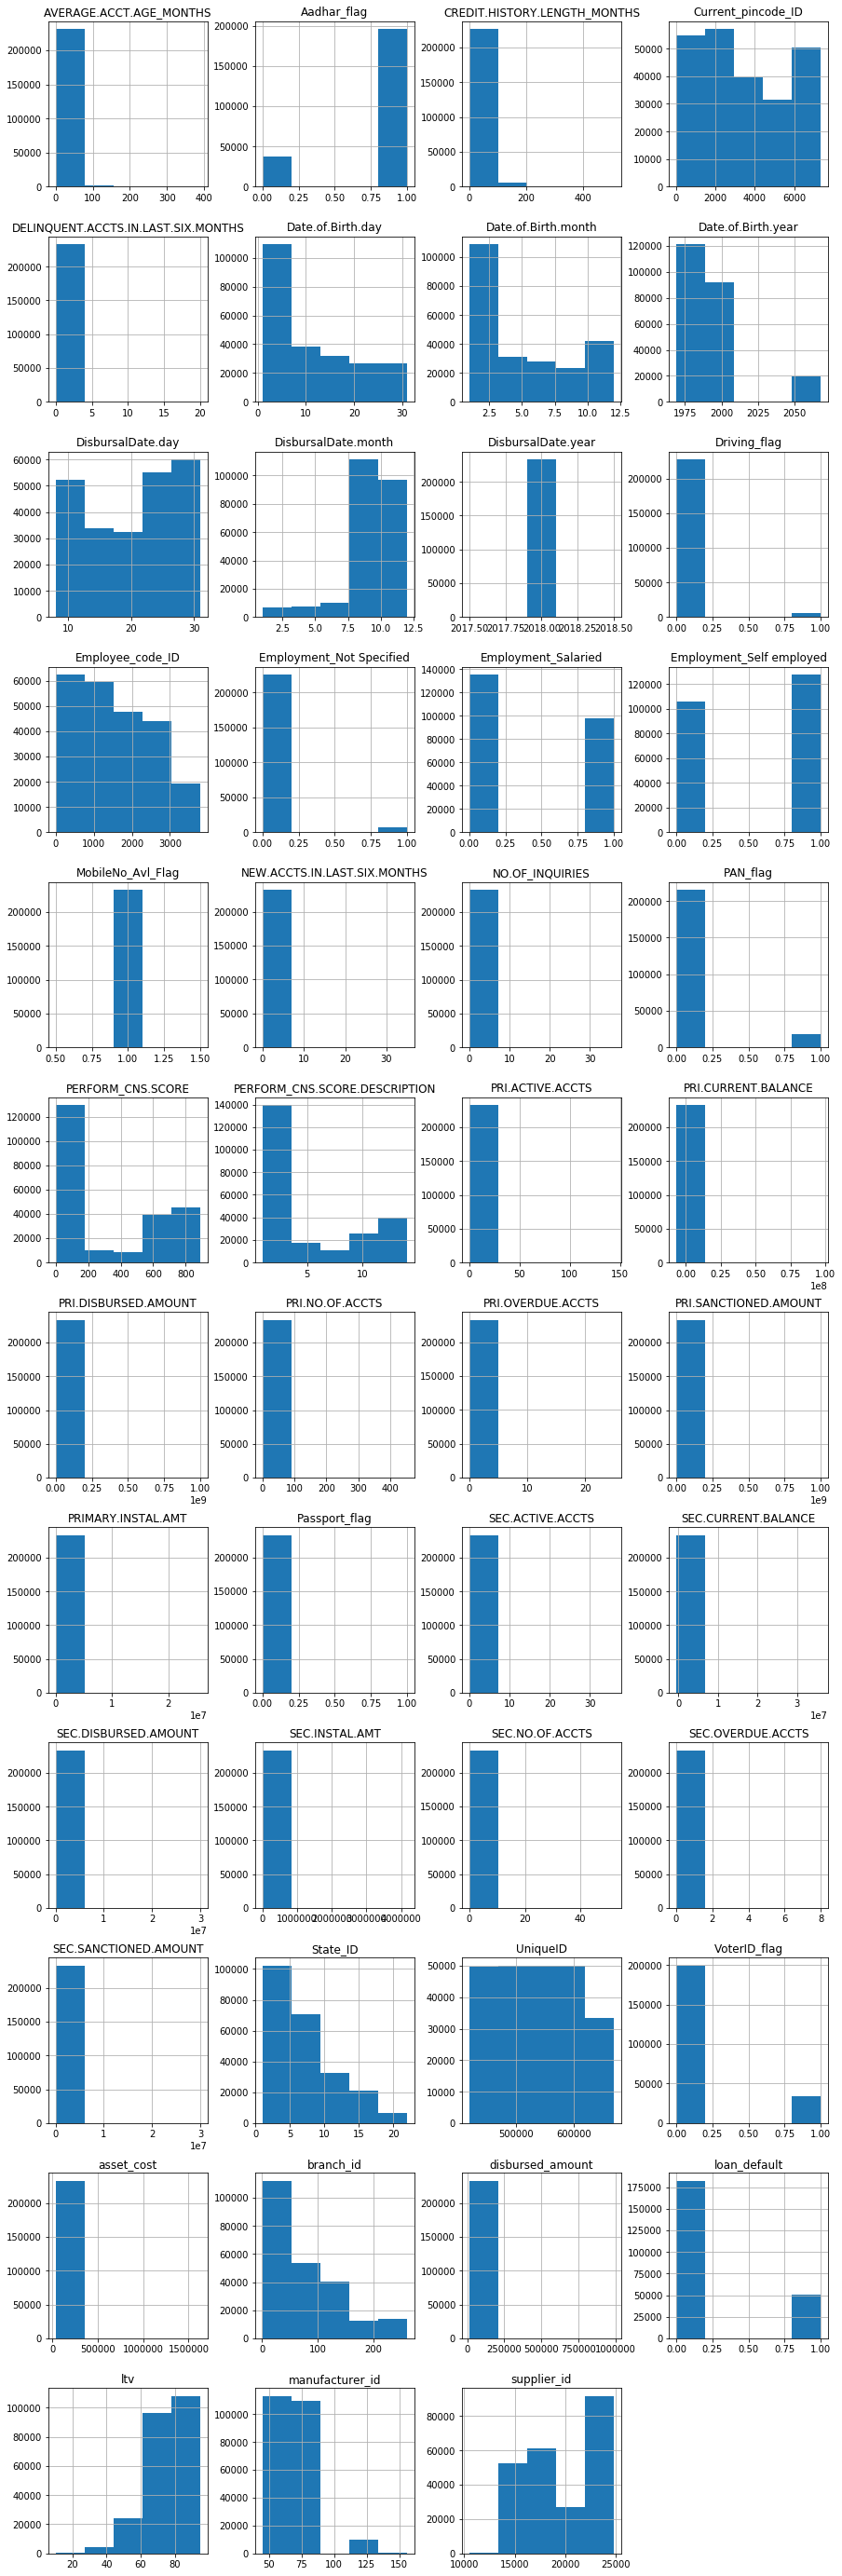

In [20]:
#fig,axes = plt.subplots(11, 1)
hist = df.hist(bins=5, figsize = (15,50), layout=(12,4))

###### 1.6.1 Handle Unique Identifier 


The customer id is a randomly generated field for unique identification purposes. 

Since the feature named 'UniqueID' is IID (independent and identically distributed), it is removed from the dataset.

In [0]:
df =df.drop(columns=['UniqueID'])

###### 1.6.2 Handle columns with only one distinct value

The feature named MobileNo_Avl_Flag have the value '1' for all instances. Since,this feature does not provide any additional information, the column is dropped.

In [22]:
df['MobileNo_Avl_Flag'].unique()

array([1])

In [0]:
df = df.drop(columns=['MobileNo_Avl_Flag'])

In [0]:
# The features were stored in a variable and the target class was stored in a different variable. 
# Split data in X (all features except labels) and y (labels)
y = df['loan_default']
df = df.drop(columns=['loan_default'])
X = df

##### 1.6.3 Handle Collinear Features

This feature selection technique allows to find the features that are highly correlated with one another. 

>In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability.[1]

[1] FROM: https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

We can see in the heatmap below the correlation between the features.


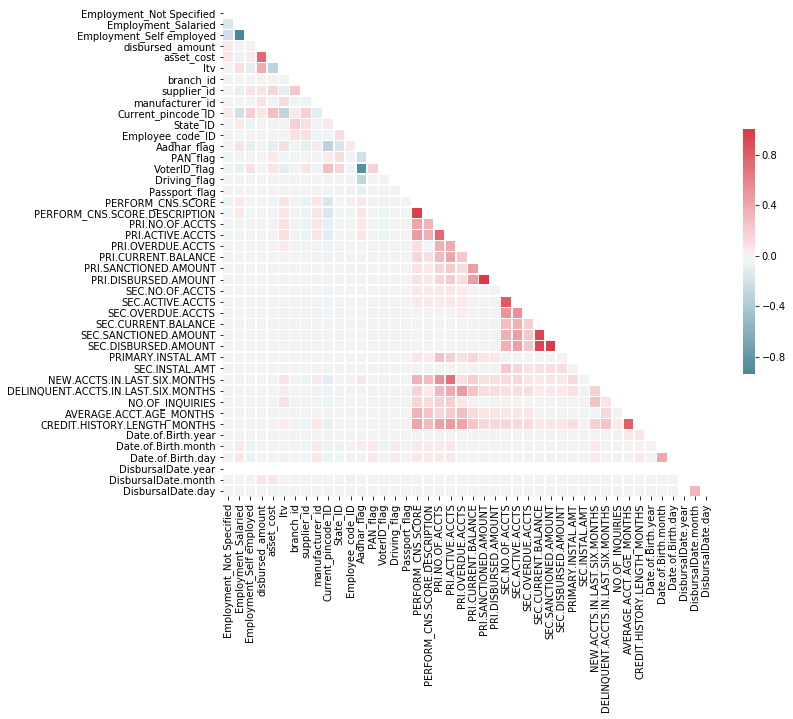

In [25]:
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


There are three pair of features with a correlation magnitude greater than 0.95 as shown in the table below.

In [26]:
fs = FeatureSelector(data = X, labels = y)
fs.identify_collinear(correlation_threshold = 0.95)

# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
fs.record_collinear.head()


3 features with a correlation magnitude greater than 0.95.



,drop_feature,corr_feature,corr_value
0,PERFORM_CNS.SCORE.DESCRIPTION,PERFORM_CNS.SCORE,0.963990
1,PRI.DISBURSED.AMOUNT,PRI.SANCTIONED.AMOUNT,0.998747
2,SEC.DISBURSED.AMOUNT,SEC.SANCTIONED.AMOUNT,0.999646


That being said, the feature named 'PERFORM_CNS.SCORE.DESCRIPTION' will be dropped since it's only a description of the credit score ('PERFORM_CNS.SCORE'). 

Also, the features 'PRI.DISBURSED.AMOUNT' and 'SEC.DISBURSED.AMOUNT' will be dropped. 

In [0]:
X = X.drop(columns=['PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT'])

##### 1.6.4 Filter Approach : Zero Importance Features

>The FeatureSelector finds feature importances using the gradient boosting machine from the LightGBM library. The feature importances are averaged over 10 training runs of the GBM in order to reduce variance. [1]


FROM: [1] https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

This approach has been selected after reading the paper named 'Gradient Boosted Feature Selection'. 

> The algorithm has been tested on several real world data sets and showed that it matches or outperforms other state of the art feature selection algorithms.

Xu, Zhixiang Eddie, et al. « Gradient Boosted Feature Selection ». arXiv:1901.04055 [cs, stat], janvier 2019. arXiv.org, http://arxiv.org/abs/1901.04055.



In [0]:
fs = FeatureSelector(data = X, labels = y)
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[391]	valid_0's auc: 0.661994
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[688]	valid_0's auc: 0.669382
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[910]	valid_0's auc: 0.672707
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[796]	valid_0's auc: 0.663982
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[625]	valid_0's auc: 0.672403
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[415]	valid_0's auc: 0.671284
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[293]	valid_0's auc: 0.67377
Training until validation scores don't improve for 100 rou

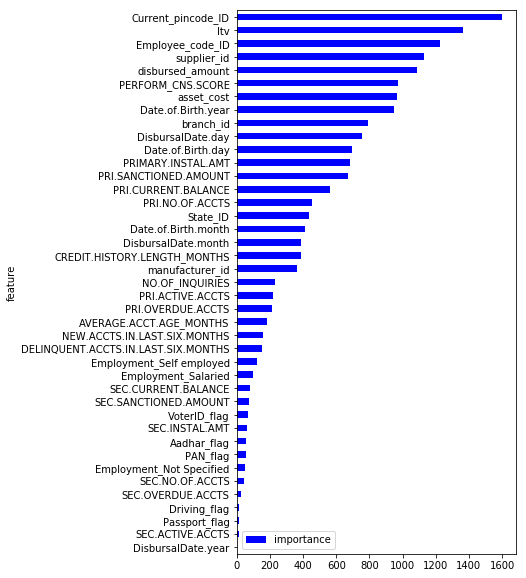

In [0]:
data_fig = pd.DataFrame({'feature': fs.feature_importances['feature'],
                         'importance': fs.feature_importances['importance'], 'cumulative_importance': 
                         fs.feature_importances['cumulative_importance'], 'num of features': range(1,len(fs.feature_importances)+1)})
data_fig = data_fig.sort_values(by='importance')
data_fig.index = data_fig['feature']
data_fig.plot.barh(y='importance',color='b', figsize=(5,10))

33 features required for 0.99 of cumulative importance


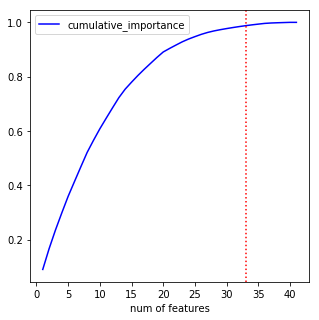

In [0]:
# plot the feature importances
data_fig = data_fig.sort_values(by='cumulative_importance')
data_fig.index = data_fig['num of features']
data_fig.plot(y='cumulative_importance',color='b', figsize=(5,5))
x = sum(data_fig['cumulative_importance'] < 0.99)
plt.axvline(x=x, color = 'red', linestyle=':')
print(x,"features required for 0.99 of cumulative importance")

The first 33 features are required for 0.99 of cumulative importance. That being said, the rest of the features will be dropped since they don't bring significant infromation to the model. 

In [0]:
columns_to_keep = data_fig[data_fig['cumulative_importance'] < 0.99]['feature'].values

In [0]:
X = X[columns_to_keep]

### 1.5 Normalization of the data

It is also important to note that the features have been normalized because some algorithms have a better performance when the data are normalized such as the nearest neighbour.

In [0]:
#features names except labels
features_name = X.columns

#normalize numerical features
transformer = Normalizer().fit(X)
X = pd.DataFrame(transformer.transform(X))
X.columns = features_name

## 2. Handle Class Imbalance





The dataset is quite imbalanced. In fact, only 50611 instances out of 233,154 have been labelled as default loan. 

[(0, 182543), (1, 50611)]


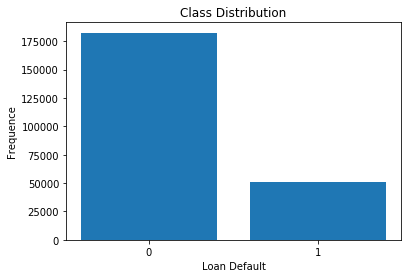

In [0]:
keys = list(collections.Counter(y).keys())
values = list(collections.Counter(y).values())
plt.title('Class Distribution')
plt.xlabel('Loan Default')
plt.ylabel('Frequence')
plt.bar(x= [str(keys[0]), str(keys[1]) ], height = values)
print(sorted(collections.Counter(y).items()))

### 2.1 Oversampling


The firstsampling technique used is the Synthetic Minority Oversampling Technique (SMOTE) which is an oversampling technique.

This technique has been selected because

Synthetic Minority Oversampling TEchnique (SMOTE) is a very popular oversampling method that was proposed to improve random oversampling [2]

In other words,

the most common oversampling technique is called SMOTE (Synthetic Minority Over-sampling Technique). [3]

[2] Blagus, R., Lusa, L. SMOTE for high-dimensional class-imbalanced data. BMC Bioinformatics 14, 106 (2013) doi:10.1186/1471-2105-14-106

[3] https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

In [0]:
# https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
X_over, y_over = SMOTE().fit_resample(X, y)
print(sorted(collections.Counter(y_over).items()))

[(0, 182543), (1, 182543)]


After applying SMOTE, 182543 instances have been labelled as loan default and 182543 have been labelled as non-loan default. 

### 2.1 Under-sampling


The second  sampling technique is called 'Near Miss'. It makes the majority class equal to minority class.

https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a7

In [0]:
X_under, y_under = NearMiss().fit_resample(X, y)
print(sorted(collections.Counter(y_under).items()))

[(0, 50611), (1, 50611)]


After applying the Near Miss algorithm, 50,611 instances have been labelled as loan default and 50,611 have been labelled as non-loan default. 

Before training the models, the python objects are saved using pickle. 

In [0]:
#pickle.dump(X, open('drive/My Drive/Colab Notebooks/pickle/X.pkl','wb'))
#pickle.dump(y, open('drive/My Drive/Colab Notebooks/pickle/y.pkl','wb'))
#pickle.dump(X_over, open('drive/My Drive/Colab Notebooks/pickle/X_over.pkl','wb'))
#pickle.dump(y_over, open('drive/My Drive/Colab Notebooks/pickle/y_over.pkl','wb'))
#pickle.dump(X_under, open('drive/My Drive/Colab Notebooks/pickle/X_under.pkl','wb'))
#pickle.dump(y_under, open('drive/My Drive/Colab Notebooks/pickle/y_under.pkl','wb'))
#pickle.dump(features_name, open('drive/My Drive/Colab Notebooks/pickle/features_name.pkl','wb'))

## 3. Train Models


### Training Preparation

In [0]:
# script to load pickle objects
#X = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/X.pkl', 'rb')) 
#y = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/y.pkl', 'rb')) 
#X_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/X_over.pkl', 'rb')) 
#y_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/y_over.pkl', 'rb'))
#X_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/X_under.pkl', 'rb')) 
#y_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/y_under.pkl', 'rb'))
#features_name = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/features_name.pkl', 'rb'))


In [0]:
# shuffle the instances in the data sets

sh_data = pd.concat([X,y], axis=1).sample(frac=1).reset_index(drop=True)
X = sh_data
y = X.pop('loan_default')

sh_data_over = pd.concat([pd.DataFrame(X_over, columns = features_name),pd.DataFrame({'loan_default':y_over})], axis=1).sample(frac=1).reset_index(drop=True)
X_over = sh_data_over
y_over = X_over.pop('loan_default')

sh_data_under = pd.concat([pd.DataFrame(X_under, columns = features_name),pd.DataFrame({'loan_default':pd.Series(y_under)})], axis=1).sample(frac=1).reset_index(drop=True)
X_under = sh_data_under
y_under = X_under.pop('loan_default')


The functions below are used to calculate the accuracy, the precision, the recall, the true negative rate and the average recall of the models. 

In [0]:
def get_mean_array(arr):
    if len(arr) == 0:
        return np.nan
    a = np.array(arr)
    return np.mean(a)


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
def cross_validation(X, y, model, type='binary', calcul = True):
    '''
    param: X, y and model
    return array
        0- average accuracy of the 10 folds
        1- average precision of the 10 folds
        2- average recall of the 10 folds
        3-  average specificity of the 10 folds
        4- average recall ( (recall + specificity)/2)
    '''
    print('Cross Validation Begin')
    skf = StratifiedKFold(n_splits=10)
    acc_sc = []
    precision_sc =[]
    recall_sc =[]
    specificity_sc = []
    avg_recall_sc =[]
    fold_num = 0 
    for train_index, test_index in skf.split(X,  y):
        fold_num  = fold_num  +1
        print('***************************************************************')
        print('FOLD ', fold_num)
        X_train, X_test =  X[train_index],  X[test_index]
        y_train, y_test =  y[train_index],  y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        acc_sc.append(accuracy)
        precision = precision_score(y_test, y_pred, average=type)
        precision_sc.append(precision)
        recall = recall_score(y_test, y_pred, average =type)
        recall_sc.append(recall)
        print('accuracy:', accuracy)
        print('recall:', recall)
        print('precision:', precision) 
        
    
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        if type == 'binary' and calcul:
            for i in range(len(y_pred)): 
                if y_test[i]==y_pred[i]==1:                    
                    TP += 1
                elif y_pred[i]==1 and y_test[i]!=y_pred[i]:
                    FP += 1
                elif y_test[i]==y_pred[i]==0:
                    TN += 1
                elif y_pred[i]==0 and y_test[i]!=y_pred[i]:
                    FN += 1
                    
             
            specificity = TN / (TN + FP)
            specificity_sc.append(specificity)
            avg_recall_sc.append((recall + specificity )/2 )
            print('specificity:', specificity)
            average_recall = (recall + specificity )/2
            print('average recall:', average_recall)   


        
    accuracy_mean = get_mean_array(acc_sc)
    acc_sc.append(accuracy_mean)
    print('Cross Validation End')
    return [acc_sc,[accuracy_mean, get_mean_array(precision_sc), get_mean_array(recall_sc), get_mean_array(specificity_sc), 
                   get_mean_array(avg_recall_sc)]]


### A.Decision Tree Classifier (tree-based) 

The first model constructed is a tree-based.

#### i. No sampling

In [0]:
scores_tree = cross_validation(X.values, y.values, tree.DecisionTreeClassifier())
algo_tree_summary = scores_tree[0]
# save model
pickle.dump(scores_tree, open('drive/My Drive/Colab Notebooks/pickle/scores_tree.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.6498691941501908
recall: 0.24298696167522718
precision: 0.22114347357065803
specificity: 0.7626951520131471
average recall: 0.5028410568441871
***************************************************************
FOLD  2
accuracy: 0.6476239492194201
recall: 0.24343015214384509
precision: 0.2192560953906389
specificity: 0.7596822788277184
average recall: 0.5015562154857818
***************************************************************
FOLD  3
accuracy: 0.6495539543661005
recall: 0.23236514522821577
precision: 0.21530574880995973
specificity: 0.7652150095864146
average recall: 0.4987900774073152
***************************************************************
FOLD  4
accuracy: 0.6506111945099721
recall: 0.2422446156885991
precision: 0.22141954126783456
specificity: 0.7638325846389833
average recall: 0.5030386001637912
***************************************************************
FOLD  5

#### ii. Oversampling

In [0]:
scores_tree_over = cross_validation(X_over.values, y_over.values, tree.DecisionTreeClassifier())
algo_tree_summary_over = scores_tree_over[0]
# save model
pickle.dump(scores_tree_over, open('drive/My Drive/Colab Notebooks/pickle/scores_tree_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7433579841139414
recall: 0.7637359627499315
precision: 0.7338280962155903
specificity: 0.7229800054779513
average recall: 0.7433579841139414
***************************************************************
FOLD  2
accuracy: 0.7428375787455491
recall: 0.7697617091207888
precision: 0.730429358561181
specificity: 0.7159134483703095
average recall: 0.7428375787455491
***************************************************************
FOLD  3
accuracy: 0.7416598192276089
recall: 0.7648863325116406
precision: 0.7309323142961839
specificity: 0.7184333059435771
average recall: 0.7416598192276089
***************************************************************
FOLD  4
accuracy: 0.7462747890873234
recall: 0.7735838720280487
precision: 0.7335203366058906
specificity: 0.718965706146598
average recall: 0.7462747890873234
***************************************************************
FOLD  5
accurac

#### iii. Undersampling



In [0]:
scores_tree_under = cross_validation(X_under.values, y_under.values, tree.DecisionTreeClassifier())
algo_tree_summary_under = scores_tree_under[0]
# save model
pickle.dump(scores_tree_under, open('drive/My Drive/Colab Notebooks/pickle/scores_tree_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.677005136309759
recall: 0.6872777558277361
precision: 0.6734417344173442
specificity: 0.6667325167917819
average recall: 0.677005136309759
***************************************************************
FOLD  2
accuracy: 0.6733847065797274
recall: 0.6761509583086347
precision: 0.6724307329534289
specificity: 0.67061845485082
average recall: 0.6733847065797274
***************************************************************
FOLD  3
accuracy: 0.6732859118751235
recall: 0.683659355858526
precision: 0.6697638404955478
specificity: 0.662912467891721
average recall: 0.6732859118751235
***************************************************************
FOLD  4
accuracy: 0.679509978265165
recall: 0.6787196206283344
precision: 0.6797941816742529
specificity: 0.6803003359019957
average recall: 0.679509978265165
***************************************************************
FOLD  5
accuracy: 0.6

### B. K-Nearest Neighbors (distance-based)

The second model is a distance-based. 


#### i. No sampling

##### Determine the value of k - no sampling

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X, y).__next__()
# find K
scores =[]
for i in range (1,50):
  knn = KNeighborsClassifier(n_neighbors=i)
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[stratified_sample[1]], y.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores.append(score)
  print('K = ', i, 'score:', score )

K =  1 score: 0.6636777128005198
K =  2 score: 0.7590643274853801
K =  3 score: 0.7163092917478883
K =  4 score: 0.7650422352176738
K =  5 score: 0.741130604288499
K =  6 score: 0.7719298245614035
K =  7 score: 0.7607537361923327
K =  8 score: 0.7742690058479532
K =  9 score: 0.7677712800519818
K =  10 score: 0.7776478232618583
K =  11 score: 0.7741390513320338
K =  12 score: 0.7806367771280052
K =  13 score: 0.7781676413255361
K =  14 score: 0.7802469135802469
K =  15 score: 0.7794671864847303
K =  16 score: 0.7818063677712801
K =  17 score: 0.7808966861598441
K =  18 score: 0.7825860948667966
K =  19 score: 0.7815464587394412
K =  20 score: 0.7823261858349577
K =  21 score: 0.7818063677712801
K =  22 score: 0.7831059129304744
K =  23 score: 0.7828460038986355
K =  24 score: 0.7832358674463937
K =  25 score: 0.7833658219623132
K =  26 score: 0.7832358674463937
K =  27 score: 0.7833658219623132
K =  28 score: 0.7832358674463937
K =  29 score: 0.7832358674463937
K =  30 score: 0.7832358

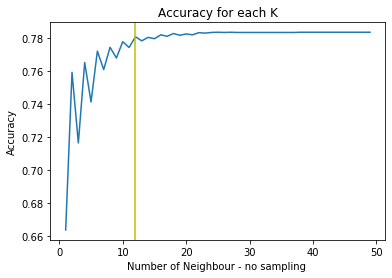

In [0]:
plt.xlabel('Number of Neighbour - no sampling ')
plt.ylabel('Accuracy')
plt.title('Accuracy for each K')
plt.plot(range(1,50), scores)
plt.axvline(x=12, color = 'y')
plt.show()

With a K value of 12
, a parsimonious model is reached as it is the simplest in term of fewest neighbours for the accuracy reached. 

##### Training the model

In [0]:
scores_k_neighbors = cross_validation(X.values, y.values, KNeighborsClassifier(n_neighbors=12))
algo_knn_summary = scores_k_neighbors[0]

# save model
pickle.dump(scores_k_neighbors, open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7775442809966977
recall: 0.005136309758988542
precision: 0.14689265536723164
specificity: 0.9917282936181868
average recall: 0.49843230168858765
***************************************************************
FOLD  2
accuracy: 0.7788214101904272
recall: 0.008496344595929657
precision: 0.23626373626373626
specificity: 0.9923856477677349
average recall: 0.5004409961818322
***************************************************************
FOLD  3
accuracy: 0.7794647452393206
recall: 0.007310808140683659
precision: 0.23870967741935484
specificity: 0.993536017529444
average recall: 0.5004234128350639
***************************************************************
FOLD  4
accuracy: 0.7791550503967403
recall: 0.007705986959098993
precision: 0.23493975903614459
specificity: 0.9930426207954421
average recall: 0.5003743038772706
***************************************************************
F

#### ii. Oversampling

##### Determine the value of K - oversampling

In [0]:
skf = StratifiedKFold(n_splits = 5)
stratified_sample = skf.split(X_over, y_over).__next__()
# find K
scores_under_k =[]
for i in range (1,30):
  knn = KNeighborsClassifier(n_neighbors=i)
  X_train, X_test, y_train, y_test = train_test_split(X_over.iloc[stratified_sample[1]], y_over.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores_under_k .append(score)
  print('K = ', i, 'score:', score )


K =  1 score: 0.6377407038512616
K =  2 score: 0.6033366533864541
K =  3 score: 0.6046646746347941
K =  4 score: 0.5935839973439575
K =  5 score: 0.5912184594953519
K =  6 score: 0.5851593625498008
K =  7 score: 0.5838728419654714
K =  8 score: 0.579722775564409
K =  9 score: 0.5760707171314741
K =  10 score: 0.5721696547144755
K =  11 score: 0.5750332005312085
K =  12 score: 0.5728336653386454
K =  13 score: 0.5730411686586986
K =  14 score: 0.5719621513944223
K =  15 score: 0.5722526560424966
K =  16 score: 0.5710491367861886
K =  17 score: 0.570011620185923
K =  18 score: 0.5695136122177955
K =  19 score: 0.5688496015936255
K =  20 score: 0.5697211155378487
K =  21 score: 0.5670235723771581
K =  22 score: 0.5678120849933599
K =  23 score: 0.5685590969455512
K =  24 score: 0.5674385790172642
K =  25 score: 0.5694721115537849
K =  26 score: 0.5682270916334662
K =  27 score: 0.5699286188579017
K =  28 score: 0.5708001328021248
K =  29 score: 0.5715886454183267


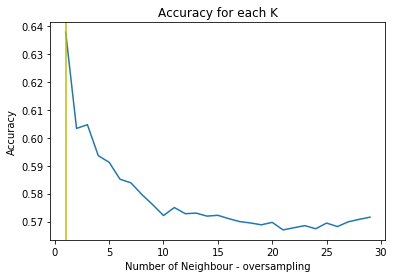

In [0]:
plt.xlabel('Number of Neighbour - oversampling')
plt.ylabel('Accuracy')
plt.title('Accuracy for each K')
plt.plot(range(1,30), scores_under_k )
plt.axvline(x=1, color = 'y')
plt.show()

With a K value of 1, a parsimonious model is reached as it is the simplest in term of fewest neighbours for the accuracy reached. 


##### Training the model

In [0]:
scores_k_neighbors_over = cross_validation(X_over.values, y_over.values, KNeighborsClassifier(n_neighbors=1))
algo_knn_summary_over = scores_k_neighbors_over[0]

# save model
pickle.dump(scores_k_neighbors_over, open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.8201314708299096
recall: 0.9379348123801698
precision: 0.759088490867175
specificity: 0.7023281292796494
average recall: 0.8201314708299097
***************************************************************
FOLD  2
accuracy: 0.823746918652424
recall: 0.9335524513831827
precision: 0.7654509522098455
specificity: 0.7139413859216653
average recall: 0.823746918652424
***************************************************************
FOLD  3
accuracy: 0.822788277184333
recall: 0.9384826075047932
precision: 0.7621335468659638
specificity: 0.707093946863873
average recall: 0.8227882771843331
***************************************************************
FOLD  4
accuracy: 0.8266681275336912
recall: 0.9410540155582338
precision: 0.7658493089612126
specificity: 0.7122822395091487
average recall: 0.8266681275336912
***************************************************************
FOLD  5
accuracy: 

#### iii. Under-sampling

##### Determine the value of k - undersampling

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X_under, y_under).__next__()
# find K
scores =[]
for i in range (1,50):
  knn = KNeighborsClassifier(n_neighbors=i)
  X_train, X_test, y_train, y_test = train_test_split(X_under.iloc[stratified_sample[1]], y_under.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores.append(score)
  print('K = ', i, 'score:', score )


K =  1 score: 0.6647710266387309
K =  2 score: 0.6961987428913499
K =  3 score: 0.6815324753067944
K =  4 score: 0.7024842861418736
K =  5 score: 0.6982939239748578
K =  6 score: 0.7078718946423227
K =  7 score: 0.7018856629751571
K =  8 score: 0.7159533073929961
K =  9 score: 0.7093684525591141
K =  10 score: 0.7087698293923975
K =  11 score: 0.7051780903920982
K =  12 score: 0.7066746483088896
K =  13 score: 0.7054774019754565
K =  14 score: 0.708171206225681
K =  15 score: 0.7099670757258306
K =  16 score: 0.7105656988925472
K =  17 score: 0.7078718946423227
K =  18 score: 0.7135588147261299
K =  19 score: 0.70487877880874
K =  20 score: 0.7090691409757558
K =  21 score: 0.7063753367255313
K =  22 score: 0.708171206225681
K =  23 score: 0.7072732714756061
K =  24 score: 0.7087698293923975
K =  25 score: 0.7123615683926968
K =  26 score: 0.7108650104759054
K =  27 score: 0.7138581263094882
K =  28 score: 0.711463633642622
K =  29 score: 0.7099670757258306
K =  30 score: 0.70966776414

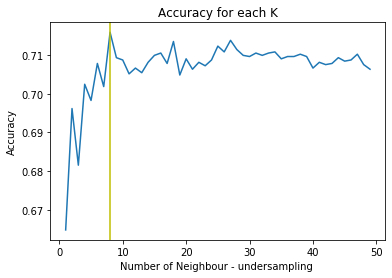

In [0]:
plt.xlabel('Number of Neighbour - undersampling ')
plt.ylabel('Accuracy')
plt.title('Accuracy for each K')
plt.plot(range(1,50), scores)
plt.axvline(x=8, color = 'y')
plt.show()

With a K value of 8, a parsimonious model is reached as it is the simplest in term of fewest neighbours for the accuracy reached. 

##### Training the model

In [0]:
scores_k_neighbors_under = cross_validation(X_under.values, y_under.values, KNeighborsClassifier(n_neighbors=8))
algo_knn_summary_under = scores_k_neighbors_under[0]

# save model
pickle.dump(scores_k_neighbors_under, open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.718984591070723
recall: 0.5272619517977084
precision: 0.8551746235181031
specificity: 0.9107072303437377
average recall: 0.7189845910707231
***************************************************************
FOLD  2
accuracy: 0.7248567476783244
recall: 0.5386287295000988
precision: 0.8583123425692695
specificity: 0.9110847658565501
average recall: 0.7248567476783244
***************************************************************
FOLD  3
accuracy: 0.7200158071527366
recall: 0.5344793519067378
precision: 0.8498272070373861
specificity: 0.9055522623987354
average recall: 0.7200158071527366
***************************************************************
FOLD  4
accuracy: 0.716854376605414
recall: 0.5210432720806165
precision: 0.8564468983436181
specificity: 0.9126654811302114
average recall: 0.716854376605414
***************************************************************
FOLD  5
accuracy

### C. SkopeRule (rule-based)

In [0]:
features_name = features_name.str.replace('.','_')

#### i. No Sampling

In [0]:
scores_rule = cross_validation(X.values, y.values, SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=features_name) )
algo_scores_rule = scores_rule[0]

# save model
pickle.dump(scores_rule, open('drive/My Drive/Colab Notebooks/pickle/scores_rule.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7829051764806794
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  2
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  3
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  4
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  5
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  6
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average

#### ii. Oversampling

In [0]:
scores_rule_over = cross_validation(X_over.values, y_over.values, SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=features_name) )
algo_scores_rule_over = scores_rule_over[0]

# save model
pickle.dump(scores_rule_over, open('drive/My Drive/Colab Notebooks/pickle/scores_rule_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.5338537387017256
recall: 0.9116954259107094
precision: 0.5192823712948518
specificity: 0.15601205149274172
average recall: 0.5338537387017256
***************************************************************
FOLD  2
accuracy: 0.5323746918652424
recall: 0.8942207614352232
precision: 0.5187821775885082
specificity: 0.17052862229526158
average recall: 0.5323746918652424
***************************************************************
FOLD  3
accuracy: 0.5500136948781156
recall: 0.8917009038619557
precision: 0.5297103807354376
specificity: 0.20832648589427555
average recall: 0.5500136948781156
***************************************************************
FOLD  4
accuracy: 0.5367316752492605
recall: 0.8935575764216063
precision: 0.5214347367411528
specificity: 0.17990577407691466
average recall: 0.5367316752492605
***************************************************************
FOLD  5
a

#### Under-sampling

In [0]:
scores_rule_under = cross_validation(X_under.values, y_under.values, SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=features_name) )
algo_scores_rule_under = scores_rule_under[0]

# save model
pickle.dump(scores_rule_under, open('drive/My Drive/Colab Notebooks/pickle/scores_rule_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.44458711971552745
recall: 0.8743579612801264
precision: 0.4702007861468182
specificity: 0.014816278150928487
average recall: 0.44458711971552745
***************************************************************
FOLD  2
accuracy: 0.4423038925113614
recall: 0.8697885793321478
precision: 0.46889646357051556
specificity: 0.014819205690574985
average recall: 0.4423038925113614
***************************************************************
FOLD  3
accuracy: 0.4429954554435882
recall: 0.8697885793321478
precision: 0.46924634900330453
specificity: 0.016202331555028652
average recall: 0.44299545544358826
***************************************************************
FOLD  4
accuracy: 0.4441809918988342
recall: 0.8784825133372851
precision: 0.4701279475520778
specificity: 0.009879470460383323
average recall: 0.4441809918988342
***************************************************************


### D.  Neural Network

#### i. No Sampling

##### Determine the parameters 

In [0]:
solver= ['sgd', 'lbfgs', 'adam']
activation = ['logistic', 'tanh', 'relu']

hidden_layer_size = [(5,), (10,), (30,), (5,5), (5,10), (5,30), (10, 10), (10, 5), (10, 30), (30,30), (30, 5), (30,10)]

learning_rate = ['invscaling', 'adaptive']  # alpha
params = list(product(solver, activation, hidden_layer_size, learning_rate))

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X, y).__next__()
# find K
scores_nn =[]
count =0
for param in params:
  # lbfgs optimizer
  nn = MLPClassifier(solver=param[0], activation = param[1],  learning_rate=param[3], hidden_layer_sizes=(param[2]), random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[stratified_sample[1]], y.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = nn.fit(X_train, y_train).score(X_test, y_test)
  scores_nn.append(score)
  print(count, 'Parameters = ', param, 'score:', score )
  count+=1
  

0 Parameters =  ('sgd', 'logistic', (5,), 'invscaling') score: 0.7815464587394412
1 Parameters =  ('sgd', 'logistic', (5,), 'adaptive') score: 0.7815464587394412
2 Parameters =  ('sgd', 'logistic', (10,), 'invscaling') score: 0.7815464587394412
3 Parameters =  ('sgd', 'logistic', (10,), 'adaptive') score: 0.7815464587394412
4 Parameters =  ('sgd', 'logistic', (30,), 'invscaling') score: 0.7815464587394412
5 Parameters =  ('sgd', 'logistic', (30,), 'adaptive') score: 0.7815464587394412
6 Parameters =  ('sgd', 'logistic', (5, 5), 'invscaling') score: 0.7815464587394412
7 Parameters =  ('sgd', 'logistic', (5, 5), 'adaptive') score: 0.7815464587394412
8 Parameters =  ('sgd', 'logistic', (5, 10), 'invscaling') score: 0.7815464587394412
9 Parameters =  ('sgd', 'logistic', (5, 10), 'adaptive') score: 0.7815464587394412
10 Parameters =  ('sgd', 'logistic', (5, 30), 'invscaling') score: 0.7815464587394412
11 Parameters =  ('sgd', 'logistic', (5, 30), 'adaptive') score: 0.7815464587394412
12 Par

In [0]:
optimizer_selected = [param[0] for param in params]
activation_selected = [param[1] for param in params]
num_layers_selected = [param[2] for param in params]
learning_rate_selected = [param[3] for param in params]


params_results = pd.DataFrame({'Accuracy':scores_nn, 'Activation Function': activation_selected,
                               "Optimizer": optimizer_selected, 'Num of layers': num_layers_selected,
                               'Learning rate': learning_rate_selected})

params_results  = params_results .sort_values(by=['Accuracy'], ascending=False)

# save object 
pickle.dump(params_results, open('drive/My Drive/Colab Notebooks/pickle/params_results.pkl','wb'))
params_results 

,Accuracy,Activation Function,Optimizer,Num of layers,Learning rate
0,0.781546,logistic,sgd,"(5,)",invscaling
136,0.781546,relu,lbfgs,"(10, 30)",invscaling
138,0.781546,relu,lbfgs,"(30, 30)",invscaling
139,0.781546,relu,lbfgs,"(30, 30)",adaptive
140,0.781546,relu,lbfgs,"(30, 5)",invscaling
141,0.781546,relu,lbfgs,"(30, 5)",adaptive
142,0.781546,relu,lbfgs,"(30, 10)",invscaling
143,0.781546,relu,lbfgs,"(30, 10)",adaptive
144,0.781546,logistic,adam,"(5,)",invscaling
145,0.781546,logistic,adam,"(5,)",adaptive


According to the results in the table above, the accuracies are really similar for different set of parameters.

That being said, I decided to select the first set of parameters in the table which is sorted by accuracy : 

Activation Function: logistic

Optimizer: sgd

num of layers : (5,)

Learning Rate : invscaling

##### Training the model

In [0]:
nn_score = cross_validation(X.values, y.values, MLPClassifier(solver='sgd', activation = 'logistic', learning_rate='invscaling', hidden_layer_sizes=(5,), random_state=1))
algo_nn_score = nn_score[0]

# save model
pickle.dump(nn_score, open('drive/My Drive/Colab Notebooks/pickle/nn_score.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7829051764806794
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  2
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  3
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  4
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  5
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  6
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average

#### i. Oversampling


##### Dertemine the parameter

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X_over, y_over).__next__()
# find K
scores_nn_over = []
count =0
for param in params:
  # lbfgs optimizer
      
  nn = MLPClassifier(solver=param[0], activation = param[1],  learning_rate=param[3], hidden_layer_sizes=(param[2]), random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X_over.iloc[stratified_sample[1]], y_over.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = nn.fit(X_train, y_train).score(X_test, y_test)
  scores_nn_over.append(score)
  print(count, 'Parameters = ', param, 'score:', score )
  count+=1

0 Parameters =  ('sgd', 'logistic', (5,), 'invscaling') score: 0.5034442692339614
1 Parameters =  ('sgd', 'logistic', (5,), 'adaptive') score: 0.4944808697817246
2 Parameters =  ('sgd', 'logistic', (10,), 'invscaling') score: 0.5034442692339614
3 Parameters =  ('sgd', 'logistic', (10,), 'adaptive') score: 0.5314963897418873
4 Parameters =  ('sgd', 'logistic', (30,), 'invscaling') score: 0.48916922566188065
5 Parameters =  ('sgd', 'logistic', (30,), 'adaptive') score: 0.472238360029878
6 Parameters =  ('sgd', 'logistic', (5, 5), 'invscaling') score: 0.5034442692339614
7 Parameters =  ('sgd', 'logistic', (5, 5), 'adaptive') score: 0.49655573076603865
8 Parameters =  ('sgd', 'logistic', (5, 10), 'invscaling') score: 0.49655573076603865
9 Parameters =  ('sgd', 'logistic', (5, 10), 'adaptive') score: 0.49655573076603865
10 Parameters =  ('sgd', 'logistic', (5, 30), 'invscaling') score: 0.5034442692339614
11 Parameters =  ('sgd', 'logistic', (5, 30), 'adaptive') score: 0.49655573076603865
12

In [0]:
optimizer_selected = [param[0] for param in params]
activation_selected = [param[1] for param in params]
num_layers_selected = [param[2] for param in params]
learning_rate_selected = [param[3] for param in params]



params_results_over = pd.DataFrame({'Accuracy':scores_over_nn[0:216], 'Activation Function': activation_selected,
                               "Optimizer": optimizer_selected, 'Num of layers': num_layers_selected,
                               'Learning rate': learning_rate_selected})

params_results_over  = params_results_over.sort_values(by=['Accuracy'], ascending=False)
# save object 
pickle.dump(params_results_over, open('drive/My Drive/Colab Notebooks/pickle/params_results_over.pkl','wb'))
params_results_over 

,Accuracy,Activation Function,Optimizer,Num of layers,Learning rate
177,0.590837,tanh,adam,"(5, 10)",adaptive
158,0.590837,logistic,adam,"(10, 5)",invscaling
145,0.590754,logistic,adam,"(5,)",adaptive
170,0.590754,tanh,adam,"(10,)",invscaling
165,0.590588,logistic,adam,"(30, 5)",adaptive
179,0.590505,tanh,adam,"(5, 30)",adaptive
146,0.590339,logistic,adam,"(10,)",invscaling
157,0.590256,logistic,adam,"(10, 10)",adaptive
144,0.590256,logistic,adam,"(5,)",invscaling
163,0.590256,logistic,adam,"(30, 30)",adaptive


According to the results in the table above which is sorted by accuracy, the highest accuracy is achieved with :

Activation Function: tanh

Optimizer: adam

num of layers : (5, 10)

Learning Rate : adaptive

##### Training the model

In [32]:
nn_score_over = cross_validation(X_over.values, y_over.values, MLPClassifier(solver='adam', activation='tanh',learning_rate='adaptive', hidden_layer_sizes=(5, 10), random_state=1))
algo_nn_score_over = nn_score_over[0]

# save model
pickle.dump(nn_score_over, open('drive/My Drive/Colab Notebooks/pickle/nn_score_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.5818132018625034
recall: 0.5706929608326486
precision: 0.5836741554148692
specificity: 0.5929334428923583
average recall: 0.5818132018625035
***************************************************************
FOLD  2
accuracy: 0.5828266228430568
recall: 0.5425910709394687
precision: 0.5900750625521268
specificity: 0.6230621747466447
average recall: 0.5828266228430568
***************************************************************
FOLD  3
accuracy: 0.5810736784442618
recall: 0.5556285949055053
precision: 0.5854207549347801
specificity: 0.6065187619830184
average recall: 0.5810736784442618
***************************************************************
FOLD  4
accuracy: 0.5835159417114058
recall: 0.6396954092253753
precision: 0.5750800295493721
specificity: 0.5273364741974362
average recall: 0.5835159417114058
***************************************************************
FOLD  5
accur

#### iii. Under-sampling

##### Determine the parameters

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X_under, y_under).__next__()
# find K
scores_nn_under = []
count =0
for param in params:
  # lbfgs optimizer
  nn = MLPClassifier(solver=param[0], activation = param[1],  learning_rate=param[3], hidden_layer_sizes=(param[2]), random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X_under.iloc[stratified_sample[1]], y_under.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = nn.fit(X_train, y_train).score(X_test, y_test)
  scores_nn_under.append(score)
  print(count, 'Parameters = ', param, 'score:', score )
  count+=1

0 Parameters =  ('sgd', 'logistic', (5,), 'invscaling') score: 0.5055372642921281
1 Parameters =  ('sgd', 'logistic', (5,), 'adaptive') score: 0.613888057467824
2 Parameters =  ('sgd', 'logistic', (10,), 'invscaling') score: 0.5055372642921281
3 Parameters =  ('sgd', 'logistic', (10,), 'adaptive') score: 0.39179886261598323
4 Parameters =  ('sgd', 'logistic', (30,), 'invscaling') score: 0.5055372642921281
5 Parameters =  ('sgd', 'logistic', (30,), 'adaptive') score: 0.5001496557916791
6 Parameters =  ('sgd', 'logistic', (5, 5), 'invscaling') score: 0.5055372642921281
7 Parameters =  ('sgd', 'logistic', (5, 5), 'adaptive') score: 0.5055372642921281
8 Parameters =  ('sgd', 'logistic', (5, 10), 'invscaling') score: 0.4944627357078719
9 Parameters =  ('sgd', 'logistic', (5, 10), 'adaptive') score: 0.4944627357078719
10 Parameters =  ('sgd', 'logistic', (5, 30), 'invscaling') score: 0.5055372642921281
11 Parameters =  ('sgd', 'logistic', (5, 30), 'adaptive') score: 0.4944627357078719
12 Par

In [0]:
optimizer_selected = [param[0] for param in params]
activation_selected = [param[1] for param in params]
num_layers_selected = [param[2] for param in params]
learning_rate_selected = [param[3] for param in params]



params_results_under = pd.DataFrame({'Accuracy':scores_under_nn[0:216], 'Activation Function': activation_selected,
                               "Optimizer": optimizer_selected, 'Num of layers': num_layers_selected,
                               'Learning rate': learning_rate_selected})
params_results_under  = params_results_under.sort_values(by=['Accuracy'], ascending=False)
# save object 
pickle.dump(params_results_under, open('drive/My Drive/Colab Notebooks/pickle/params_results_under.pkl','wb'))
params_results_under

,Accuracy,Activation Function,Optimizer,Num of layers,Learning rate
184,0.731518,tanh,adam,"(10, 30)",invscaling
188,0.731218,tanh,adam,"(30, 5)",invscaling
185,0.730021,tanh,adam,"(10, 30)",adaptive
187,0.729123,tanh,adam,"(30, 30)",adaptive
152,0.727926,logistic,adam,"(5, 10)",invscaling
190,0.727327,tanh,adam,"(30, 10)",invscaling
146,0.727028,logistic,adam,"(10,)",invscaling
191,0.725831,tanh,adam,"(30, 10)",adaptive
183,0.724933,tanh,adam,"(10, 5)",adaptive
203,0.724933,relu,adam,"(5, 30)",adaptive


According to the results in the table above which is sorted by accuracy, the highest accuracy is achieved with :

Activation Function: tanh

Optimizer: adam

num of layers : (10, 30)

Learning Rate : invscaling

##### Training the model

In [33]:
nn_score_under = cross_validation(X_under.values, y_under.values, MLPClassifier(solver='adam', activation = 'tanh', learning_rate='invscaling', hidden_layer_sizes=(10, 30), random_state=1))
algo_nn_score_under = nn_score_under[0]

# save model
pickle.dump(nn_score_under, open('drive/My Drive/Colab Notebooks/pickle/nn_score_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7118727775582774
recall: 0.5790201501382852
precision: 0.7885391444713479
specificity: 0.8447254049782694
average recall: 0.7118727775582774
***************************************************************
FOLD  2
accuracy: 0.7313771981821774
recall: 0.5455443588223671
precision: 0.8682389937106918
specificity: 0.9172100375419877
average recall: 0.7313771981821774
***************************************************************
FOLD  3
accuracy: 0.7311796087729697
recall: 0.5435684647302904
precision: 0.8700189753320683
specificity: 0.918790752815649
average recall: 0.7311796087729697
***************************************************************
FOLD  4
accuracy: 0.7113218731475993
recall: 0.5945465323058684
precision: 0.7757153905645785
specificity: 0.8280972139893301
average recall: 0.7113218731475992
***************************************************************
FOLD  5
accura

### E. SGDClassifier ( Linear Classifier)

##### i. No sampling

In [0]:
sgd_score = cross_validation(X.values, y.values, SGDClassifier())
algo_sgd_score  = sgd_score[0]

# save model
pickle.dump(sgd_score , open('drive/My Drive/Colab Notebooks/pickle/sgd_score.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7829051764806794
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  2
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  3
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  4
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  5
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  6
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average

#### i.Oversampling

In [0]:
sgd_score_over = cross_validation(X_over.values, y_over.values, SGDClassifier())
algo_sgd_score_over  = sgd_score_over[0]

# save model
pickle.dump(sgd_score_over , open('drive/My Drive/Colab Notebooks/pickle/sgd_score_over.pkl','wb'))


Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.5626129827444536
recall: 0.6810188989317995
precision: 0.5506245017273452
specificity: 0.4442070665571076
average recall: 0.5626129827444535
***************************************************************
FOLD  2
accuracy: 0.5594083812654067
recall: 0.7425362914270063
precision: 0.5434826189807946
specificity: 0.3762804711038072
average recall: 0.5594083812654067
***************************************************************
FOLD  3
accuracy: 0.5665844973979731
recall: 0.7228704464530266
precision: 0.5507282667668294
specificity: 0.41029854834291973
average recall: 0.5665844973979731
***************************************************************
FOLD  4
accuracy: 0.5602333735071765
recall: 0.742686534458201
precision: 0.5441300421432872
specificity: 0.3777802125561521
average recall: 0.5602333735071765
***************************************************************
FOLD  5
accur

#### Under-sampling

In [0]:
sgd_score_under = cross_validation(X_under.values, y_under.values, SGDClassifier())
algo_sgd_score_under  = sgd_score_under[0]

# save model
pickle.dump(sgd_score_under , open('drive/My Drive/Colab Notebooks/pickle/sgd_score_under.pkl','wb'))


Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.674930857368629
recall: 0.352627419992098
precision: 0.9922178988326849
specificity: 0.99723429474516
average recall: 0.674930857368629
***************************************************************
FOLD  2
accuracy: 0.6703220707370084
recall: 0.340644141474017
precision: 1.0
specificity: 1.0
average recall: 0.6703220707370086
***************************************************************
FOLD  3
accuracy: 0.6674570243034973
recall: 0.3351116380162023
precision: 0.9994107248084856
specificity: 0.9998024105907923
average recall: 0.6674570243034973
***************************************************************
FOLD  4
accuracy: 0.6721991701244814
recall: 0.344793519067378
precision: 0.9988551803091014
specificity: 0.9996048211815847
average recall: 0.6721991701244814
***************************************************************
FOLD  5
accuracy: 0.6757557794902194
recall: 0.352

### F.  XGBoost ( Ensemble)

#### i. No Sampling

In [0]:
boost_score = cross_validation(X.values, y.values, model = XGBClassifier())
algo_boost_score = boost_score[0]

# save model
pickle.dump(boost_score, open('drive/My Drive/Colab Notebooks/pickle/boost_score.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7829051764806794
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  2
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  3
accuracy: 0.7829387545033454
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  4
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  5
accuracy: 0.7829294445635857
recall: 0.0
precision: 0.0
specificity: 1.0
average recall: 0.5
***************************************************************
FOLD  6
accuracy: 0.7829723354063908
recall: 0.00019758940920766647
precision: 1.0
speci

#### ii. Oversampling

In [0]:
boost_score_over = cross_validation(X_over.values, y_over.values, model = XGBClassifier())
algo_boost_score_over = boost_score_over[0]

# save model
pickle.dump(boost_score_over, open('drive/My Drive/Colab Notebooks/pickle/boost_score_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.761709120788825
recall: 0.6161051766639277
precision: 0.8692325527475075
specificity: 0.9073130649137223
average recall: 0.761709120788825
***************************************************************
FOLD  2
accuracy: 0.7608052588331964
recall: 0.6130923034784991
precision: 0.8701601617166848
specificity: 0.9085182141878937
average recall: 0.7608052588331964
***************************************************************
FOLD  3
accuracy: 0.760093125171186
recall: 0.6151191454396056
precision: 0.8663014966826107
specificity: 0.9050671049027663
average recall: 0.760093125171186
***************************************************************
FOLD  4
accuracy: 0.7600525912128848
recall: 0.6118111098937219
precision: 0.8696464725120697
specificity: 0.9082940725320477
average recall: 0.7600525912128848
***************************************************************
FOLD  5
accuracy:

#### Under-sampling

In [0]:
boost_score_under = cross_validation(X_under.values, y_under.values, model = XGBClassifier())
algo_boost_score_under = boost_score_under[0]

# save model
pickle.dump(boost_score_under, open('drive/My Drive/Colab Notebooks/pickle/boost_score_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7449624654286843
recall: 0.533781114184117
precision: 0.9240766073871409
specificity: 0.9561438166732517
average recall: 0.7449624654286844
***************************************************************
FOLD  2
accuracy: 0.7440229203714681
recall: 0.5311203319502075
precision: 0.9249827942188575
specificity: 0.9569255087927288
average recall: 0.7440229203714681
***************************************************************
FOLD  3
accuracy: 0.7449120727129026
recall: 0.5309227425409998
precision: 0.9281519861830743
specificity: 0.9589014028848054
average recall: 0.7449120727129026
***************************************************************
FOLD  4
accuracy: 0.7383916222090496
recall: 0.5176842521240862
precision: 0.9267775026529891
specificity: 0.9590989922940131
average recall: 0.7383916222090496
***************************************************************
FOLD  5
accura

### G.  Random Forest ( Ensemble)

#### i. No sampling

##### Determine the number of trees - no sampling



In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X, y).__next__()
# find K
scores =[]
for i in range (1,50):
  knn = RandomForestClassifier(n_estimators=i, random_state=0)

  X_train, X_test, y_train, y_test = train_test_split(X.iloc[stratified_sample[1]], y.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores.append(score)
  print('Number of trees = ', i, 'score:', score )


Number of trees =  1 score: 0.6549707602339181
Number of trees =  2 score: 0.7463287849252761
Number of trees =  3 score: 0.6952566601689408
Number of trees =  4 score: 0.7491877842755036
Number of trees =  5 score: 0.7233268356075374
Number of trees =  6 score: 0.7577647823261858
Number of trees =  7 score: 0.7386614684860299
Number of trees =  8 score: 0.7607537361923327
Number of trees =  9 score: 0.7503573749187784
Number of trees =  10 score: 0.7651721897335932
Number of trees =  11 score: 0.7560753736192333
Number of trees =  12 score: 0.7676413255360623
Number of trees =  13 score: 0.7632228719948018
Number of trees =  14 score: 0.7702404158544509
Number of trees =  15 score: 0.7668615984405458
Number of trees =  16 score: 0.7721897335932424
Number of trees =  17 score: 0.7671215074723846
Number of trees =  18 score: 0.7727095516569201
Number of trees =  19 score: 0.7681611435997401
Number of trees =  20 score: 0.7728395061728395
Number of trees =  21 score: 0.7690708252111761
N

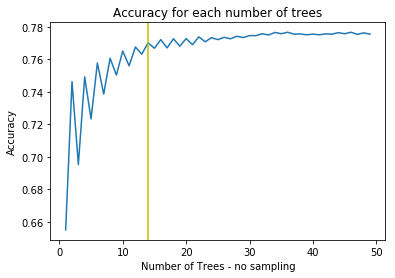

In [0]:
plt.xlabel('Number of Trees - no sampling')
plt.ylabel('Accuracy')
plt.title('Accuracy for each number of trees')
plt.plot(range(1,50), scores)
plt.axvline(x=14, color = 'y')
plt.show()

With a number of tree of 15, a parsimonious model is reached as it is the simplest in term of fewest trees for the accuracy reached. 

##### Training the model

In [0]:
random_score = cross_validation(X.values, y.values, RandomForestClassifier(n_estimators=15, random_state=0))
algo_random_score  = random_score[0]

# save model
pickle.dump(random_score , open('drive/My Drive/Colab Notebooks/pickle/random_score.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.7702105759746108
recall: 0.023508494666139867
precision: 0.22284644194756553
specificity: 0.9772665023281293
average recall: 0.5003874984971346
***************************************************************
FOLD  2
accuracy: 0.7702436095385143
recall: 0.02529144437858131
precision: 0.2318840579710145
specificity: 0.9767734867159682
average recall: 0.5010324655472748
***************************************************************
FOLD  3
accuracy: 0.768999828443987
recall: 0.02687215965224264
precision: 0.22780569514237856
specificity: 0.9747466447548617
average recall: 0.5008094022035522
***************************************************************
FOLD  4
accuracy: 0.7701050825648724
recall: 0.024698676150958308
precision: 0.22768670309653916
specificity: 0.9767722143091925
average recall: 0.5007354452300754
***************************************************************
FOLD 

#### ii. Oversampling

##### Determine the number of trees - oversampling

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X_over, y_over).__next__()
# find K
scores =[]
for i in range (1,100):
  knn = RandomForestClassifier(n_estimators=i, random_state=0)

  X_train, X_test, y_train, y_test = train_test_split(X_over.iloc[stratified_sample[1]], y_over.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores.append(score)
  print('Number of trees = ', i, 'score:', score )

Number of trees =  1 score: 0.6267740061415885
Number of trees =  2 score: 0.6393061664868454
Number of trees =  3 score: 0.6548261266495145
Number of trees =  4 score: 0.6661963648435555
Number of trees =  5 score: 0.6767366586438709
Number of trees =  6 score: 0.6834592082330484
Number of trees =  7 score: 0.6886878579135198
Number of trees =  8 score: 0.6979832351232468
Number of trees =  9 score: 0.6971532907295211
Number of trees =  10 score: 0.7078595734085816
Number of trees =  11 score: 0.7040418291974437
Number of trees =  12 score: 0.7130882230890531
Number of trees =  13 score: 0.7135031952859159
Number of trees =  14 score: 0.7208897003900738
Number of trees =  15 score: 0.71914681716325
Number of trees =  16 score: 0.7278612332973691
Number of trees =  17 score: 0.7222176114200348
Number of trees =  18 score: 0.7308490331147813
Number of trees =  19 score: 0.7272802722217612
Number of trees =  20 score: 0.730351066478546
Number of trees =  21 score: 0.7301020831604282
Numb

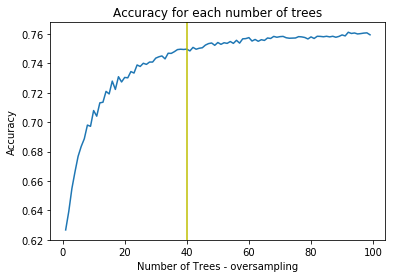

In [0]:
plt.xlabel('Number of Trees - oversampling')
plt.ylabel('Accuracy')
plt.title('Accuracy for each number of trees')
plt.plot(range(1,100), scores)
plt.axvline(x=40, color = 'y')
plt.show()

With a number of tree of 40, a parsimonious model is reached as it is the simplest in term of fewest trees for the accuracy reached. 

In [0]:
random_score_over = cross_validation(X_over.values, y_over.values, RandomForestClassifier(n_estimators=40, random_state=0))
algo_random_score_over  = random_score_over[0]

# save model
pickle.dump(random_score_over, open('drive/My Drive/Colab Notebooks/pickle/random_score_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.8555464256368118
recall: 0.8070665571076417
precision: 0.8937215650591447
specificity: 0.9040262941659819
average recall: 0.8555464256368118
***************************************************************
FOLD  2
accuracy: 0.8531909066009312
recall: 0.8061353053957819
precision: 0.8898832920118522
specificity: 0.9002465078060805
average recall: 0.8531909066009312
***************************************************************
FOLD  3
accuracy: 0.8552177485620378
recall: 0.8113941385921666
precision: 0.8893425397778445
specificity: 0.899041358531909
average recall: 0.8552177485620378
***************************************************************
FOLD  4
accuracy: 0.853703297907308
recall: 0.8039333844636792
precision: 0.8928028228995559
specificity: 0.9034732113509368
average recall: 0.853703297907308
***************************************************************
FOLD  5
accuracy

#### Under-sampling

##### Determine the number of trees - undersampling

In [0]:
skf = StratifiedKFold(n_splits = 10)
stratified_sample = skf.split(X_under, y_under).__next__()
# find K
scores =[]
for i in range (1,100):
  knn = RandomForestClassifier(n_estimators=i, random_state=0)

  X_train, X_test, y_train, y_test = train_test_split(X_under.iloc[stratified_sample[1]], y_under.iloc[stratified_sample[1]], test_size=0.33, random_state=42,
                                                      )
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  scores.append(score)
  print('Number of trees = ', i, 'score:', score )

Number of trees =  1 score: 0.6740496857228375
Number of trees =  2 score: 0.7027835977252319
Number of trees =  3 score: 0.6935049386411254
Number of trees =  4 score: 0.7108650104759054
Number of trees =  5 score: 0.6988925471415743
Number of trees =  6 score: 0.714756061059563
Number of trees =  7 score: 0.7078718946423227
Number of trees =  8 score: 0.720143669560012
Number of trees =  9 score: 0.7156539958096378
Number of trees =  10 score: 0.7231367853935947
Number of trees =  11 score: 0.7210416043100868
Number of trees =  12 score: 0.7219395390601616
Number of trees =  13 score: 0.7243340317270278
Number of trees =  14 score: 0.7276264591439688
Number of trees =  15 score: 0.7243340317270278
Number of trees =  16 score: 0.7261299012271775
Number of trees =  17 score: 0.7258305896438192
Number of trees =  18 score: 0.7318168213109847
Number of trees =  19 score: 0.7282250823106854
Number of trees =  20 score: 0.7339120023944926
Number of trees =  21 score: 0.7315175097276264
Num

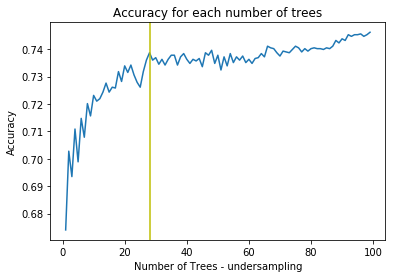

In [0]:
plt.xlabel('Number of Trees - undersampling')
plt.ylabel('Accuracy')
plt.title('Accuracy for each number of trees')
plt.plot(range(1,100), scores)
plt.axvline(x=28, color = 'y')
plt.show()

With a number of tree of 28, a parsimonious model is reached as it is the simplest in term of fewest trees for the accuracy reached. 


##### Training the model

In [0]:
random_score_under = cross_validation(X_under.values, y_under.values, RandomForestClassifier(n_estimators=28, random_state=0))
algo_random_score_under  = random_score_under[0]

# save model
pickle.dump(random_score_under, open('drive/My Drive/Colab Notebooks/pickle/random_score_under.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.74239431054919
recall: 0.6056894508099565
precision: 0.833605220228385
specificity: 0.8790991702884235
average recall: 0.74239431054919
***************************************************************
FOLD  2
accuracy: 0.7449120727129026
recall: 0.6166765461371271
precision: 0.8293914429976083
specificity: 0.8731475992886781
average recall: 0.7449120727129026
***************************************************************
FOLD  3
accuracy: 0.7430349733254298
recall: 0.608970559178028
precision: 0.83207343412527
specificity: 0.8770993874728314
average recall: 0.7430349733254298
***************************************************************
FOLD  4
accuracy: 0.7382928275044458
recall: 0.5981031416716064
precision: 0.8311367380560132
specificity: 0.8784825133372851
average recall: 0.7382928275044458
***************************************************************
FOLD  5
accuracy: 0.7

## 4. Model Evaluation

### Load Scores

In [0]:
'''# a. decision trees
scores_tree = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_tree.pkl', 'rb'))
scores_tree_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_tree_over.pkl', 'rb'))
scores_tree_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_tree_under.pkl', 'rb'))

# b. knn
scores_knn = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors.pkl', 'rb')) 
scores_knn_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors_over.pkl', 'rb')) 
scores_knn_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_k_neighbors_under.pkl', 'rb'))

#c. skope rules
scores_rules = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_rule.pkl', 'rb'))
scores_rules_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_rule_over.pkl', 'rb'))
scores_rules_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/scores_rule_under.pkl', 'rb')) 

# d. neural network
scores_nn = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/nn_score.pkl', 'rb')) 
scores_nn_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/nn_score_over.pkl', 'rb')) 
scores_nn_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/nn_score_under.pkl', 'rb')) 

# e. sgd classifier
scores_sgd = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/sgd_score.pkl', 'rb')) 
scores_sgd_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/sgd_score_over.pkl', 'rb')) 
scores_sgd_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/sgd_score_under.pkl', 'rb')) 

# f. xgboost
scores_boost = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/boost_score.pkl', 'rb'))
scores_boost_over = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/boost_score_over.pkl', 'rb'))
scores_boost_under = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/boost_score_under.pkl', 'rb'))

# g. random forest
scores_random = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/random_score.pkl', 'rb')) 
scores_random_over  = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/random_score_over.pkl', 'rb')) 
scores_random_under  = pickle.load(open('drive/My Drive/Colab Notebooks/pickle/random_score_under.pkl', 'rb'))
''' 


### Gather the results

The table below demontrates the acronyms use in this section.


In [34]:
acronyms= pd.DataFrame({'Acronym': ['DT', 'KNN', 'RB','NN', 'SGD', 'XGB', 'RF'],
                        'Definition': ['Decision Tree', 'K-Nearest Neighbors', 'Rule-Based',
                                       'Neural Network', 'Stochastic Gradient Descent ',
                                       'XGBosst', 'Random Forest'],
                       })
acronyms

,Acronym,Definition
0,DT,Decision Tree
1,KNN,K-Nearest Neighbors
2,RB,Rule-Based
3,NN,Neural Network
4,SGD,Stochastic Gradient Descent
5,XGB,XGBosst
6,RF,Random Forest


In [0]:
# return the wanted results - no sampling
def get_results_by_index_no_sampling(i):
  return [scores_tree[1][i], scores_knn[1][i],scores_rules[1][i], scores_nn[1][i], 
          scores_sgd[1][i], scores_boost[1][i], scores_random[1][i] ]

# return the wanted results - over sampling
def get_results_by_index_over_sampling(i):
  return [scores_tree_over[1][i], scores_knn_over[1][i],scores_rules_over[1][i], scores_nn_over[1][i], 
          scores_sgd_over[1][i], scores_boost_over[1][i], scores_random_over[1][i] ]

# return the wanted results - under sampling
def get_results_by_index_under_sampling(i):
  return [scores_tree_under[1][i], scores_knn_under[1][i],scores_rules_under[1][i], scores_nn_under[1][i], 
          scores_sgd_under[1][i], scores_boost_under[1][i], scores_random_under[1][i] ]

#### i. Accuracies

The table below demonstrates the accuracies of algorithms.

In [40]:
# store all accuracies
accuracies= pd.DataFrame({'Algorithm': ['DT', 'KNN', 'RB','NN', 'SGD', 'XGB', 'RF'],
                        'No sampling': get_results_by_index_no_sampling(0),
                        'Oversampling':get_results_by_index_over_sampling(0),
                        'Undersampling': get_results_by_index_under_sampling(0),
                       })

accuracies

,Algorithm,No sampling,Oversampling,Undersampling
0,DT,0.649352,0.756846,0.754367
1,KNN,0.779116,0.837551,0.720367
2,RB,0.782929,0.539865,0.443777
3,NN,0.782929,0.582926,0.725100
4,SGD,0.782929,0.561013,0.671830
5,XGB,0.782933,0.761259,0.742507
6,RF,0.769882,0.857724,0.739365


#### ii. Recall

The table below desmonstrates the recalls of the algorithms.

In [41]:
# store all recalls
recalls= pd.DataFrame({'Algorithm': ['DT', 'KNN', 'RB','NN', 'SGD', 'XGB', 'RF'],
                        'No sampling': get_results_by_index_no_sampling(2),
                        'Oversampling':get_results_by_index_over_sampling(2),
                        'Undersampling': get_results_by_index_under_sampling(2),
                       })

recalls

,Algorithm,No sampling,Oversampling,Undersampling
0,DT,0.237596,0.783377,0.764591
1,KNN,0.007805,0.955795,0.528462
2,RB,0.000000,0.899876,0.874355
3,NN,0.000000,0.630833,0.524193
4,SGD,0.000000,0.718669,0.344866
5,XGB,0.000020,0.613231,0.526664
6,RF,0.024698,0.826822,0.604493


#### iii. Precision

The table below desmonstrates the precisions of the algorithms.

In [43]:
# store all precisions
precisions= pd.DataFrame({'Algorithm': ['DT', 'KNN', 'RB','NN', 'SGD', 'XGB', 'RF'],
                        'No sampling': get_results_by_index_no_sampling(1),
                        'Oversampling':get_results_by_index_over_sampling(1),
                        'Undersampling': get_results_by_index_under_sampling(1),
                       })

precisions

,Algorithm,No sampling,Oversampling,Undersampling
0,DT,0.217875,0.737961,0.750454
1,KNN,0.235924,0.773090,0.857658
2,RB,0.000000,0.523241,0.469787
3,NN,0.000000,0.576798,0.885323
4,SGD,0.000000,0.546767,0.996561
5,XGB,0.100000,0.871150,0.926718
6,RF,0.225521,0.879789,0.827811


#### iv. Average Recall

The table below desmonstrates the average recall of the algorithms.

In [44]:
# store all average recalls
avg_recalls= pd.DataFrame({'Algorithm': ['DT', 'KNN', 'RB','NN', 'SGD', 'XGB', 'RF'],
                        'No sampling': get_results_by_index_no_sampling(4),
                        'Oversampling':get_results_by_index_over_sampling(4),
                        'Undersampling': get_results_by_index_under_sampling(4),
                       })

avg_recalls

,Algorithm,No sampling,Oversampling,Undersampling
0,DT,0.500555,0.756846,0.754367
1,KNN,0.500385,0.837551,0.720367
2,RB,0.500000,0.539865,0.443777
3,NN,0.500000,0.582926,0.725100
4,SGD,0.500000,0.561013,0.671830
5,XGB,0.500010,0.761259,0.742507
6,RF,0.500593,0.857724,0.739365


In the result tables, it is possible to see that the recall and precision for the original data set ( no sampling) are often equal to 0% or below 50%. It means that the true positives are very low. That being said, the models are not able to classify the minority class correclty. 

The original data set ( no sampling) will no longer be considered in the evaluation.

The under sampled and oversampled datasets have the same number of positive and negative instances. The being said, “average recall is the evaluation measure of choice if all class distributions are equally likely” [Flach]  which is “the average of the true positive rate and the true negative rate” [Flach].  

For all algorithms, the oversampled dataset has the highest average recall except for the SGD and the neural network. Since 4 algorithms out of have a higher average recall with the oversampled dataset, the undersampled data set will no longer be considered in the evaluation. 


Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

### Paired-t Test

The table below demonstrates the average recall of algorithms against each one of the ten folds when trained against the over-sampling technique. 

In [45]:
# import data
avg_recall_over = pd.read_csv('result_over.csv', encoding = "ISO-8859-1")
avg_recall_over

,Fold,DT,KNN,RB,NN,SGD,XGB,RF
0,1,0.743358,0.820131,0.533854,0.586004,0.562613,0.761709,0.855546
1,2,0.742838,0.823747,0.532375,0.582142,0.559408,0.760805,0.853191
2,3,0.741660,0.822788,0.550014,0.580060,0.566584,0.760093,0.855218
3,4,0.746275,0.826668,0.536732,0.578120,0.560233,0.760053,0.853703
4,5,0.743645,0.821436,0.540786,0.583434,0.559220,0.761614,0.852279
5,6,0.741043,0.821519,0.552893,0.580339,0.561685,0.758847,0.854005
6,7,0.744303,0.822422,0.536704,0.583379,0.554755,0.762682,0.852252
7,8,0.743015,0.821929,0.538156,0.579681,0.558535,0.764052,0.849403
8,9,0.743919,0.820587,0.534376,0.583899,0.566643,0.761148,0.850964
9,10,0.747453,0.823272,0.542758,0.580859,0.560453,0.761587,0.854607


The table below demonstrates the average recall difference between each pair of algorithms.

In [46]:
paired_results = pd.DataFrame()

paired_results['Fold']=[1,2,3,4,5,6,7,8,9,10]
# DT
paired_results['DT-KNN'] = avg_recall_over['DT'] - avg_recall_over['KNN']
paired_results['DT-RB'] = avg_recall_over['DT'] - avg_recall_over['RB']
paired_results['DT-NN'] = avg_recall_over['DT'] - avg_recall_over['NN']
paired_results['DT-SGD'] = avg_recall_over['DT'] - avg_recall_over['SGD']
paired_results['DT-XGB'] = avg_recall_over['DT'] - avg_recall_over['XGB']
paired_results['DT-RF'] = avg_recall_over['DT'] - avg_recall_over['RF']
# KNN
paired_results['KNN-RB'] = avg_recall_over['KNN'] - avg_recall_over['RB']
paired_results['KNN-NN'] = avg_recall_over['KNN'] - avg_recall_over['NN']
paired_results['KNN-SGD'] = avg_recall_over['KNN'] - avg_recall_over['SGD']
paired_results['KNN-XGB'] = avg_recall_over['KNN'] - avg_recall_over['XGB']
paired_results['KNN-RF'] = avg_recall_over['KNN'] - avg_recall_over['RF']
#RB
paired_results['RB-NN'] = avg_recall_over['RB'] - avg_recall_over['NN']
paired_results['RB-SGD'] = avg_recall_over['RB'] - avg_recall_over['SGD']
paired_results['RB-XGB'] = avg_recall_over['RB'] - avg_recall_over['XGB']
paired_results['RB-RF'] = avg_recall_over['RB'] - avg_recall_over['RF']
#NN
paired_results['NN-SGD'] = avg_recall_over['NN'] - avg_recall_over['SGD']
paired_results['NN-XGB'] = avg_recall_over['NN'] - avg_recall_over['XGB']
paired_results['NN-RF'] = avg_recall_over['NN'] - avg_recall_over['RF']
#SGD
paired_results['SGD-XGB'] = avg_recall_over['SGD'] - avg_recall_over['XGB']
paired_results['SGD-RF'] = avg_recall_over['SGD'] - avg_recall_over['RF']
#XGB
paired_results['XGB-RF'] = avg_recall_over['XGB'] - avg_recall_over['RF']

paired_results

,Fold,DT-KNN,DT-RB,DT-NN,DT-SGD,DT-XGB,DT-RF,KNN-RB,KNN-NN,KNN-SGD,KNN-XGB,KNN-RF,RB-NN,RB-SGD,RB-XGB,RB-RF,NN-SGD,NN-XGB,NN-RF,SGD-XGB,SGD-RF,XGB-RF
0,1,-0.076773,0.209504,0.157354,0.180745,-0.018351,-0.112188,0.286278,0.234128,0.257518,0.058422,-0.035415,-0.052150,-0.028759,-0.227855,-0.321693,0.023391,-0.175705,-0.269543,-0.199096,-0.292933,-0.093837
1,2,-0.080909,0.210463,0.160696,0.183429,-0.017968,-0.110353,0.291372,0.241605,0.264339,0.062942,-0.029444,-0.049767,-0.027034,-0.228431,-0.320816,0.022733,-0.178663,-0.271049,-0.201397,-0.293783,-0.092386
2,3,-0.081128,0.191646,0.161600,0.175075,-0.018433,-0.113558,0.272775,0.242728,0.256204,0.062695,-0.032429,-0.030047,-0.016571,-0.210079,-0.305204,0.013476,-0.180033,-0.275157,-0.193509,-0.288633,-0.095125
3,4,-0.080393,0.209543,0.168155,0.186041,-0.013778,-0.107429,0.289936,0.248548,0.266435,0.066616,-0.027035,-0.041388,-0.023502,-0.223321,-0.316972,0.017886,-0.181933,-0.275583,-0.199819,-0.293470,-0.093651
4,5,-0.077791,0.202860,0.160211,0.184425,-0.017969,-0.108634,0.280651,0.238003,0.262217,0.059823,-0.030843,-0.042648,-0.018434,-0.220828,-0.311493,0.024214,-0.178180,-0.268845,-0.202394,-0.293059,-0.090665
5,6,-0.080476,0.188151,0.160705,0.179358,-0.017804,-0.112962,0.268626,0.241180,0.259833,0.062671,-0.032486,-0.027446,-0.008793,-0.205955,-0.301112,0.018653,-0.178509,-0.273666,-0.197162,-0.292319,-0.095157
6,7,-0.078120,0.207598,0.160924,0.189547,-0.018380,-0.107949,0.285718,0.239043,0.267667,0.059740,-0.029829,-0.046675,-0.018051,-0.225978,-0.315547,0.028624,-0.179303,-0.268873,-0.207927,-0.297496,-0.089569
7,8,-0.078914,0.204859,0.163334,0.184480,-0.021036,-0.106388,0.283773,0.242248,0.263394,0.057878,-0.027473,-0.041525,-0.020379,-0.225896,-0.311247,0.021146,-0.184371,-0.269722,-0.205517,-0.290868,-0.085351
8,9,-0.076668,0.209543,0.160020,0.177276,-0.017229,-0.107045,0.286211,0.236688,0.253944,0.059439,-0.030377,-0.049523,-0.032267,-0.226772,-0.316588,0.017256,-0.177249,-0.267065,-0.194505,-0.284321,-0.089816
9,10,-0.075819,0.204695,0.166594,0.187000,-0.014134,-0.107155,0.280514,0.242413,0.262819,0.061685,-0.031336,-0.038101,-0.017695,-0.218829,-0.311849,0.020406,-0.180728,-0.273748,-0.201134,-0.294155,-0.093021


To know if there is a statistically significant difference in the average recalls obtained by the algorithms, the paired t-test will be used.

In [0]:
summary_stats = pd.DataFrame()
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)

In [48]:
paired_results_summary = paired_results.append(summary_stats.T)
paired_results_summary.iloc[11,0] = np.nan
paired_results_summary.iloc[10,0] = np.nan
paired_results_summary

,Fold,DT-KNN,DT-RB,DT-NN,DT-SGD,DT-XGB,DT-RF,KNN-RB,KNN-NN,KNN-SGD,KNN-XGB,KNN-RF,RB-NN,RB-SGD,RB-XGB,RB-RF,NN-SGD,NN-XGB,NN-RF,SGD-XGB,SGD-RF,XGB-RF
0,1.0,-0.076773,0.209504,0.157354,0.180745,-0.018351,-0.112188,0.286278,0.234128,0.257518,0.058422,-0.035415,-0.052150,-0.028759,-0.227855,-0.321693,0.023391,-0.175705,-0.269543,-0.199096,-0.292933,-0.093837
1,2.0,-0.080909,0.210463,0.160696,0.183429,-0.017968,-0.110353,0.291372,0.241605,0.264339,0.062942,-0.029444,-0.049767,-0.027034,-0.228431,-0.320816,0.022733,-0.178663,-0.271049,-0.201397,-0.293783,-0.092386
2,3.0,-0.081128,0.191646,0.161600,0.175075,-0.018433,-0.113558,0.272775,0.242728,0.256204,0.062695,-0.032429,-0.030047,-0.016571,-0.210079,-0.305204,0.013476,-0.180033,-0.275157,-0.193509,-0.288633,-0.095125
3,4.0,-0.080393,0.209543,0.168155,0.186041,-0.013778,-0.107429,0.289936,0.248548,0.266435,0.066616,-0.027035,-0.041388,-0.023502,-0.223321,-0.316972,0.017886,-0.181933,-0.275583,-0.199819,-0.293470,-0.093651
4,5.0,-0.077791,0.202860,0.160211,0.184425,-0.017969,-0.108634,0.280651,0.238003,0.262217,0.059823,-0.030843,-0.042648,-0.018434,-0.220828,-0.311493,0.024214,-0.178180,-0.268845,-0.202394,-0.293059,-0.090665
5,6.0,-0.080476,0.188151,0.160705,0.179358,-0.017804,-0.112962,0.268626,0.241180,0.259833,0.062671,-0.032486,-0.027446,-0.008793,-0.205955,-0.301112,0.018653,-0.178509,-0.273666,-0.197162,-0.292319,-0.095157
6,7.0,-0.078120,0.207598,0.160924,0.189547,-0.018380,-0.107949,0.285718,0.239043,0.267667,0.059740,-0.029829,-0.046675,-0.018051,-0.225978,-0.315547,0.028624,-0.179303,-0.268873,-0.207927,-0.297496,-0.089569
7,8.0,-0.078914,0.204859,0.163334,0.184480,-0.021036,-0.106388,0.283773,0.242248,0.263394,0.057878,-0.027473,-0.041525,-0.020379,-0.225896,-0.311247,0.021146,-0.184371,-0.269722,-0.205517,-0.290868,-0.085351
8,9.0,-0.076668,0.209543,0.160020,0.177276,-0.017229,-0.107045,0.286211,0.236688,0.253944,0.059439,-0.030377,-0.049523,-0.032267,-0.226772,-0.316588,0.017256,-0.177249,-0.267065,-0.194505,-0.284321,-0.089816
9,10.0,-0.075819,0.204695,0.166594,0.187000,-0.014134,-0.107155,0.280514,0.242413,0.262819,0.061685,-0.031336,-0.038101,-0.017695,-0.218829,-0.311849,0.020406,-0.180728,-0.273748,-0.201134,-0.294155,-0.093021


In [0]:
summary_stats = pd.DataFrame()

summary_stats['Fold']=[np.nan]
#DT
summary_stats['DT-KNN'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['KNN'])[1]]
summary_stats['DT-RB'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['RB'])[1]]
summary_stats['DT-NN'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['NN'])[1]]
summary_stats['DT-SGD'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['SGD'])[1]]
summary_stats['DT-XGB'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['XGB'])[1]]
summary_stats['DT-RF'] = [stats.ttest_rel(avg_recall_over['DT'], avg_recall_over['RF'])[1]]
#KNN
summary_stats['KNN-RB'] = [stats.ttest_rel(avg_recall_over['KNN'], avg_recall_over['RB'])[1]]
summary_stats['KNN-NN'] = [stats.ttest_rel(avg_recall_over['KNN'], avg_recall_over['NN'])[1]]
summary_stats['KNN-SGD'] = [stats.ttest_rel(avg_recall_over['KNN'], avg_recall_over['SGD'])[1]]
summary_stats['KNN-XGB'] = [stats.ttest_rel(avg_recall_over['KNN'], avg_recall_over['XGB'])[1]]
summary_stats['KNN-RF'] = [stats.ttest_rel(avg_recall_over['KNN'], avg_recall_over['RF'])[1]]
#RB
summary_stats['RB-NN'] = [stats.ttest_rel(avg_recall_over['RB'], avg_recall_over['NN'])[1]]
summary_stats['RB-SGD'] = [stats.ttest_rel(avg_recall_over['RB'], avg_recall_over['SGD'])[1]]
summary_stats['RB-XGB'] = [stats.ttest_rel(avg_recall_over['RB'], avg_recall_over['XGB'])[1]]
summary_stats['RB-RF'] = [stats.ttest_rel(avg_recall_over['RB'], avg_recall_over['RF'])[1]]
#NN
summary_stats['NN-SGD'] = [stats.ttest_rel(avg_recall_over['NN'], avg_recall_over['SGD'])[1]]
summary_stats['NN-XGB'] = [stats.ttest_rel(avg_recall_over['NN'], avg_recall_over['XGB'])[1]]
summary_stats['NN-RF'] = [stats.ttest_rel(avg_recall_over['NN'], avg_recall_over['RF'])[1]]
#SGD
summary_stats['SGD-XGB'] = [stats.ttest_rel(avg_recall_over['SGD'], avg_recall_over['XGB'])[1]]
summary_stats['SGD-RF'] = [stats.ttest_rel(avg_recall_over['SGD'], avg_recall_over['RF'])[1]]
#XGB
summary_stats['XGB-RF'] = [stats.ttest_rel(avg_recall_over['XGB'], avg_recall_over['RF'])[1]]
paired_results_summary = paired_results_summary.append(summary_stats)

paired_results_summary.to_csv('avg_recall.csv')

The table below demonstrates the calculation of a paired t-test on the results. The numbers show pairwise differences in each fold. The null hypothesis is that the “differences come from a normal distribution with mean 0 and unknown standard deviation” [Flach].

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

In [50]:
paired_results_summary

,Fold,DT-KNN,DT-RB,DT-NN,DT-SGD,DT-XGB,DT-RF,KNN-RB,KNN-NN,KNN-SGD,KNN-XGB,KNN-RF,RB-NN,RB-SGD,RB-XGB,RB-RF,NN-SGD,NN-XGB,NN-RF,SGD-XGB,SGD-RF,XGB-RF
0,1.0,-7.677349e-02,2.095042e-01,1.573541e-01,1.807450e-01,-1.835114e-02,-1.121884e-01,2.862777e-01,2.341276e-01,2.575185e-01,5.842235e-02,-3.541496e-02,-5.215010e-02,-0.028759,-2.278554e-01,-3.216927e-01,2.339085e-02,-1.757053e-01,-2.695426e-01,-1.990961e-01,-2.929334e-01,-9.383730e-02
1,2.0,-8.090934e-02,2.104629e-01,1.606957e-01,1.834292e-01,-1.796768e-02,-1.103533e-01,2.913722e-01,2.416050e-01,2.643385e-01,6.294166e-02,-2.944399e-02,-4.976719e-02,-0.027034,-2.284306e-01,-3.208162e-01,2.273350e-02,-1.786634e-01,-2.710490e-01,-2.013969e-01,-2.937825e-01,-9.238565e-02
2,3.0,-8.112846e-02,1.916461e-01,1.615996e-01,1.750753e-01,-1.843331e-02,-1.135579e-01,2.727746e-01,2.427280e-01,2.562038e-01,6.269515e-02,-3.242947e-02,-3.004656e-02,-0.016571,-2.100794e-01,-3.052041e-01,1.347576e-02,-1.800329e-01,-2.751575e-01,-1.935086e-01,-2.886333e-01,-9.512462e-02
3,4.0,-8.039334e-02,2.095431e-01,1.681549e-01,1.860414e-01,-1.377780e-02,-1.074285e-01,2.899365e-01,2.485483e-01,2.664348e-01,6.661554e-02,-2.703517e-02,-4.138819e-02,-0.023502,-2.233209e-01,-3.169716e-01,1.788649e-02,-1.819327e-01,-2.755834e-01,-1.998192e-01,-2.934699e-01,-9.365071e-02
4,5.0,-7.779117e-02,2.028596e-01,1.602115e-01,1.844253e-01,-1.796866e-02,-1.086337e-01,2.806508e-01,2.380026e-01,2.622165e-01,5.982251e-02,-3.084255e-02,-4.264819e-02,-0.018434,-2.208283e-01,-3.114934e-01,2.421387e-02,-1.781801e-01,-2.688452e-01,-2.023940e-01,-2.930591e-01,-9.066506e-02
5,6.0,-8.047551e-02,1.881505e-01,1.607045e-01,1.793579e-01,-1.780432e-02,-1.129615e-01,2.686261e-01,2.411800e-01,2.598335e-01,6.267119e-02,-3.248603e-02,-2.744604e-02,-0.008793,-2.059549e-01,-3.011121e-01,1.865345e-02,-1.785088e-01,-2.736660e-01,-1.971623e-01,-2.923195e-01,-9.515723e-02
6,7.0,-7.811986e-02,2.075983e-01,1.609236e-01,1.895475e-01,-1.837953e-02,-1.079489e-01,2.857182e-01,2.390435e-01,2.676674e-01,5.974033e-02,-2.982908e-02,-4.667470e-02,-0.018051,-2.259779e-01,-3.155473e-01,2.862386e-02,-1.793032e-01,-2.688726e-01,-2.079270e-01,-2.974964e-01,-8.956941e-02
7,8.0,-7.891421e-02,2.048592e-01,1.633341e-01,1.844801e-01,-2.103648e-02,-1.063876e-01,2.837734e-01,2.422483e-01,2.633943e-01,5.787772e-02,-2.747343e-02,-4.152514e-02,-0.020379,-2.258957e-01,-3.112468e-01,2.114605e-02,-1.843705e-01,-2.697217e-01,-2.055166e-01,-2.908678e-01,-8.535116e-02
8,9.0,-7.666813e-02,2.095431e-01,1.600197e-01,1.772762e-01,-1.722910e-02,-1.070450e-01,2.862112e-01,2.366879e-01,2.539443e-01,5.943903e-02,-3.037690e-02,-4.952339e-02,-0.032267,-2.267722e-01,-3.165881e-01,1.725649e-02,-1.772488e-01,-2.670648e-01,-1.945053e-01,-2.843212e-01,-8.981593e-02
9,10.0,-7.581900e-02,2.046949e-01,1.665936e-01,1.870001e-01,-1.413389e-02,-1.071546e-01,2.805139e-01,2.424126e-01,2.628191e-01,6.168511e-02,-3.133560e-02,-3.810124e-02,-0.017695,-2.188288e-01,-3.118495e-01,2.040649e-02,-1.807275e-01,-2.737482e-01,-2.011340e-01,-2.941547e-01,-9.302071e-02


“The p-value in the last line of the table is calculated by means of the t-distribution with k − 1 = 9 degrees of freedom "[Flach]. 

There is a statistically difference in the average recall obtained between all the algorithms at the α = 0.05 level ( since no p-value is inferior to α ).  

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

Since there is a statistically difference between the algorithms, it is possible to say the the random forest performs better than the other algorithms based on the average recall.


## H. Voting Ensemble

A majority ensemble will be built with the best tree algorithms: Random Forest, KNN and XGBoost using the oversampled dataset. 

### Train the model

In [52]:
from sklearn.ensemble import VotingClassifier
estimators = []
model1 = KNeighborsClassifier(n_neighbors=1)
estimators.append(('Decision Tree', model1))
model2 = XGBClassifier()
estimators.append(('XGBClassifier', model2))
model3 =  RandomForestClassifier(n_estimators=40, random_state=0)
estimators.append(('random forest', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)

voting_score_over = cross_validation(X_over.values, y_over.values, ensemble)
algo_voting_score_over  = voting_score_over[0]

# save model
#pickle.dump(voting_score_over, open('drive/My Drive/Colab Notebooks/pickle/voting_score_over.pkl','wb'))

Cross Validation Begin
***************************************************************
FOLD  1
accuracy: 0.8608326485894275
recall: 0.8168173103259381
precision: 0.8956631427198463
specificity: 0.904847986852917
average recall: 0.8608326485894275
***************************************************************
FOLD  2
accuracy: 0.8659271432484251
recall: 0.8240482059709668
precision: 0.8993782135597274
specificity: 0.9078060805258833
average recall: 0.865927143248425
***************************************************************
FOLD  3
accuracy: 0.8626403725006847
recall: 0.8212544508353876
precision: 0.8953655040611562
specificity: 0.9040262941659819
average recall: 0.8626403725006848
***************************************************************
FOLD  4
accuracy: 0.8626054563383369
recall: 0.8204777035170374
precision: 0.8959679349126586
specificity: 0.9047332091596363
average recall: 0.8626054563383369
***************************************************************
FOLD  5
accurac

### Evaluate the model

We want to know, if this ensemble is better than the random forest.
To do so, the paired-t test will be used. 

In [53]:
# import data
avg_recall_majority = pd.read_csv('majority_voting.csv', encoding = "ISO-8859-1")
avg_recall_majority

,Fold,RF,Majority Voting
0,1,0.855546,0.865598
1,2,0.853191,0.861819
2,3,0.855218,0.861380
3,4,0.853703,0.861647
4,5,0.852279,0.865728
5,6,0.854005,0.863674
6,7,0.852252,0.865947
7,8,0.849403,0.864276
8,9,0.850964,0.866112
9,10,0.854607,0.861072


In [54]:
p_value = stats.ttest_rel(avg_recall_majority['RF'], avg_recall_majority['Majority Voting'])[1]
p_value

4.246616051131363e-06

The p-value  with k − 1 = 9 degrees of freedom is 4.246616051131363e-06. 

There is a statistically difference in the average recall obtained between the two algorithms.


That being said, the majority vote ensemble is the best algorithm based on the average recall.
